#### **1) Libraries**

In [ ]:
# !pip install -U tensorflow_probability -q
# !pip install -q ipdb

In [ ]:
# prerequisites
import numpy as np
import pandas as pd
import math
import matplotlib
import matplotlib.pyplot as plt
# import seaborn as sns
# sns.set()
import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Input, InputLayer, Lambda, Reshape, Dropout, \
                                    Flatten, Dense, Conv2D, Conv2DTranspose  
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
import tensorflow_probability as tfp
from tensorflow_probability import distributions
import tensorflow_datasets as tfds
from scipy.stats import norm, gmean
from scipy import ndimage
from six.moves import urllib
import gzip
import time
import os

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

If using Google Colab, save in your Google Drive.

In [ ]:
from google.colab import drive

drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


#### **2) CIFAR Data**

Preprocess image

In [ ]:
IMAGE_SIZE = 32
NUM_CHANNELS = 3
PIXEL_DEPTH = 255
NUM_LABELS = 10
VALIDATION_SIZE = 0  

# Load the 10 class cifar data set.
dataset, metadata = tfds.load('cifar10', as_supervised=True, with_info=True)
# Split into training and testing data sets.
train_dataset, test_dataset = dataset['train'], dataset['test']

def normalize(images, labels):
  '''Normalizes pixel values to be between 0 and 1.'''
  images = tf.cast(images, tf.float32)
  images /= 255
  return images, labels

# The map function applies the normalize function to each element in the train
# and test datasets to get the pixel values between 0 and 1.
train_dataset =  train_dataset.map(normalize)
test_dataset  =  test_dataset.map(normalize)

# Separate the images from their labels in the training dataset
X_train = np.array([list(x[0].numpy().reshape(-1)) for x in list(train_dataset)])
y_train = np.array([x[1].numpy() for x in list(train_dataset)])

# Separate the images from their labels in the testing dataset
X_test = np.array([list(x[0].numpy().reshape(-1)) for x in list(test_dataset)])
y_test = np.array([x[1].numpy() for x in list(test_dataset)])

train_size = X_train.shape[0]
test_size = X_test.shape[0]

Shuffling and writing examples to /root/tensorflow_datasets/cifar10/3.0.2.incompleteGCQFUJ/cifar10-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/cifar10/3.0.2.incompleteGCQFUJ/cifar10-test.tfrecord


Dataset cifar10 downloaded and prepared to /root/tensorflow_datasets/cifar10/3.0.2. Subsequent calls will reuse this data.


In [ ]:
# Create a dictionary to convert integer labels to descriptive string labels.
label_dict = {0: 'airplane',
              1: 'automobile',
              2: 'bird',
              3: 'cat',
              4: 'deer',
              5: 'dog',
              6: 'frog',
              7: 'horse',
              8: 'ship',
              9: 'truck'}

# Create a list to hold the integer labels of mammals.
mammal_labels = [3, 4, 5, 7]

# Get the indices of the observations corresponding to mammals in the training and testing data sets.
train_mammal_indicies = pd.Series(y_train).isin(mammal_labels)
test_mammal_indicies = pd.Series(y_test).isin(mammal_labels)

# Subset the data for the mammal observations.
X_train = X_train[train_mammal_indicies]
y_train = y_train[train_mammal_indicies]
X_test = X_test[test_mammal_indicies]
y_test = y_test[test_mammal_indicies]

In [ ]:
X_train.shape, y_train.shape

((20000, 3072), (20000,))

In [ ]:
X_test.shape, y_test.shape

((4000, 3072), (4000,))

In [ ]:
SOURCE_URL = 'http://yann.lecun.com/exdb/mnist/'
DATA_DIRECTORY = "data"

IMAGE_SIZE = 28
NUM_CHANNELS = 1
PIXEL_DEPTH = 255
NUM_LABELS = 10
VALIDATION_SIZE = 0  

# DOWNLOAD
def try_download(filename):
    if not tf.io.gfile.exists(DATA_DIRECTORY):
        tf.io.gfile.makedirs(DATA_DIRECTORY)
    filepath = os.path.join(DATA_DIRECTORY, filename)
    if not tf.io.gfile.exists(filepath):
        filepath, _ = urllib.request.urlretrieve(SOURCE_URL + filename, filepath)
        with tf.io.gfile.GFile(filepath) as f:
            size = f.size()
        print('Successfully downloaded', filename, size, 'bytes.')
    return filepath

# GET IMAGES
def get_data(filename, num_images, norm_shift=False, norm_scale=True):
    print('geting', filename)
    with gzip.open(filename) as bytestream:
        bytestream.read(16)
        buf = bytestream.read(IMAGE_SIZE * IMAGE_SIZE * num_images * NUM_CHANNELS)
        data = np.frombuffer(buf, dtype=np.uint8).astype(np.float32)
        if norm_shift:
            data = data - (PIXEL_DEPTH / 2.0)
        if norm_scale:
            data = data / PIXEL_DEPTH
        data = data.reshape(num_images, IMAGE_SIZE, IMAGE_SIZE, NUM_CHANNELS)
        data = np.reshape(data, [num_images, -1])
    return data

# GET LABELS
def get_labels(filename, num_images):
    """get the labels into a vector of int64 label IDs."""
    print('geting', filename)
    with gzip.open(filename) as bytestream:
        bytestream.read(8)
        buf = bytestream.read(1 * num_images)
        labels = np.frombuffer(buf, dtype=np.uint8).astype(np.int64)
        num_labels_data = len(labels)
        one_hot_encoding = np.zeros((num_labels_data,NUM_LABELS))
        one_hot_encoding[np.arange(num_labels_data),labels] = 1
        one_hot_encoding = np.reshape(one_hot_encoding, [-1, NUM_LABELS])
    return one_hot_encoding

# Augment training data
def expend_training_data(images, labels):

    expanded_images = []
    expanded_labels = []

    j = 0 
    for x, y in zip(images, labels):
        j = j+1
        if j%100==0:
            print ('expanding data : %03d / %03d' % (j, np.size(images,0)))

        # register original data
        expanded_images.append(x)
        expanded_labels.append(y)

        # get a value for the background
        # zero is the expected value, but median() is used to estimate background's value
        bg_value = np.median(x) 
        image = np.reshape(x, (-1, 28))

        for i in range(4):
            angle = np.random.randint(-15,15,1)
            new_img = ndimage.rotate(image,angle,reshape=False, cval=bg_value)

            # shift the image with random distance
            shift = np.random.randint(-2, 2, 2)
            new_img_ = ndimage.shift(new_img,shift, cval=bg_value)

            # register new training data
            expanded_images.append(np.reshape(new_img_, 784))
            expanded_labels.append(y)

    # images and labels are concatenated for random-shuffle at each epoch
    # notice that pair of image and label should not be broken
    expanded_train_total_data = np.concatenate((expanded_images, expanded_labels), axis=1)
    np.random.shuffle(expanded_train_total_data)

    return expanded_train_total_data

# MNIST DATA
def prepare_MNIST_data(use_norm_shift=False, use_norm_scale=True, use_data_augmentation=False):
    # Get the data.
    train_data_filename = try_download('train-images-idx3-ubyte.gz')
    train_labels_filename = try_download('train-labels-idx1-ubyte.gz')
    test_data_filename = try_download('t10k-images-idx3-ubyte.gz')
    test_labels_filename = try_download('t10k-labels-idx1-ubyte.gz')

    # get it into numpy arrays.
    train_data = get_data(train_data_filename, 60000, use_norm_shift, use_norm_scale)
    train_labels = get_labels(train_labels_filename, 60000)
    test_data = get_data(test_data_filename, 10000, use_norm_shift, use_norm_scale)
    test_labels = get_labels(test_labels_filename, 10000)

    # Generate a validation set.
    validation_data = train_data[:VALIDATION_SIZE, :]
    validation_labels = train_labels[:VALIDATION_SIZE,:]
    train_data = train_data[VALIDATION_SIZE:, :]
    train_labels = train_labels[VALIDATION_SIZE:,:]

    # Concatenate train_data & train_labels for random shuffle
    if use_data_augmentation:
        train_total_data = expend_training_data(train_data, train_labels)
    else:
        train_total_data = np.concatenate((train_data, train_labels), axis=1)

    train_size = train_total_data.shape[0]

    return train_total_data, train_size, train_data, train_labels, test_data, test_labels

In [ ]:
train_total_data, train_size, X_train, y_train, X_test, y_test = prepare_MNIST_data(use_norm_shift=False, use_norm_scale=True, use_data_augmentation=False)
temp = np.argmax(y_test, axis=1)
y_test = temp

Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
geting data/train-images-idx3-ubyte.gz
geting data/train-labels-idx1-ubyte.gz
geting data/t10k-images-idx3-ubyte.gz
geting data/t10k-labels-idx1-ubyte.gz


In [ ]:
X_train.shape, y_train.shape

((60000, 784), (60000, 10))

In [ ]:
X_test.shape[-1], y_test.shape

(784, (10000,))

#### **3) Model Class**

In [ ]:
import numpy as np
import pandas as pd
import math
from typing import Any, List  # for NDArray types

def generalized_mean(values: np.ndarray, r: float = 1.0, weights: np.ndarray = None) -> float:
    """
    This function calculates the generalized mean of a 1-D array of non- 
    negative real numbers using the coupled logarithm and exponential functions.
    
    Parameters
    ----------
    values : np.ndarray
        DESCRIPTION : A 1-D numpy array (row vector) of non-negative numbers
         for which we are calculating the generalized mean.
    r : float, optional
        DESCRIPTION : The risk bias and the power of the generalized mean. 
        The default is 1.0 (Arithmetric Mean).
    weights : np.ndarray, optional
        DESCRIPTION : A 1-D numpy array of the weights for each value. 
        The default is None, which triggers a conditional to use equal weights.

    Returns gen_mean
    -------
    float
        DESCRIPTION : The coupled generalized mean.
    """
    
    assert type(values) == np.ndarray, "values must be a 1-D numpy ndarray."
    if len(values.shape) != 1:
        assert ((len(values.shape) == 2) 
                & ((values.shape[0] == 1)
                  | (values.shape[1] == 1))), "values must be a 1-D numpy ndarray."
    assert (values <= 0).sum() == 0, "all numbers in values must be greater than 0."
    assert ((type(r) == int) | (type(r) == float) | (type(r) == np.int32 ) 
            | (type(r) == np.float32) | (type(r) == np.int64) 
            | (type(r) == np.float64)), "r must be a numeric data type, like a float or int."
    assert ((type(weights) == type(None))
            | (type(weights) == np.ndarray)), "weights must either be None or 1-D numpy ndarray."
            
    # If weights equals None, equally weight all observations.
    if type(weights) == type(None):
        weights = weights or np.ones(len(values))
    
    # Calculate the log of the generalized mean by taking the dot product of the
    # weights vector and the vector of the coupled logarithm of the values and
    # divide the result by the sum of the the weights.
    log_gen_mean = np.dot(weights, coupled_logarithm(values, kappa=r, dim=0)) / np.sum(weights)
        
    # Calculate the generalized mean by exponentiating the log-generalized mean.
    gen_mean = coupled_exponential(log_gen_mean, kappa=r, dim=0)
    
    # Return the generalized mean.
    return gen_mean

def coupled_logarithm(value: [float, Any], kappa: float = 0.0, dim: int = 1) -> [float, Any]:
    """
    Generalization of the logarithm function, which defines smooth
    transition to power functions.
    Inputs
    ----------
    x : Input variable in which the coupled logarithm is applied to.
    kappa : Coupling parameter which modifies the coupled logarithm function.
    dim : The dimension of x, or rank if x is a tensor. Not needed?
    """
    if isinstance(value, float):    
        assert value >= 0, "x must be greater or equal to 0."  # Greater than 0?????
    else:
        assert isinstance(value, np.ndarray), "x must be a np.ndarray type if a sequence, or a float if a scalar."
        # assert np.all(x), "all values in x must be "

    if kappa == 0:
        coupled_log_value = np.log(value)  # divide by 0 if x == 0
    else:
        coupled_log_value = (1 / kappa) * (value**(kappa / (1 + dim*kappa)) - 1)
    return coupled_log_value


def coupled_exponential(value: float, kappa: float = 0.0, dim: int = 1) -> float:
    """
    Short description
    ----------
    x : Input variable in which the coupled exponential is applied to.
    kappa : Coupling parameter which modifies the coupled exponential function.
    dim : The dimension of x, or rank if x is a tensor.
    """
    assert dim >= 0, "dim must be greater than or equal 0."
        # may also want to test that dim is an integer

        # removed the requirement on kappa; although not common kappa can be less than -1/dim
    if kappa == 0:
        coupled_exp_value = math.exp(value)
    else:
        if kappa > 0:
        	coupled_exp_value = (1 + kappa*value)**(1/(kappa / (1 + dim*kappa))) # removed negative sign and added reciprocal
        # now given that kappa < 0
        elif (1 + kappa*value) >= 0:
       		coupled_exp_value = (1 + kappa*value)**(1/(kappa / (1 + dim*kappa))) # removed negative sign and added reciprocal
        elif (kappa / (1 + dim*kappa)) > 0: # removed negative sign
       		coupled_exp_value = 0
        else:
       		coupled_exp_value = float('inf')
        # else:
        # 	print("Error: kappa = 1/d is not greater than -1.")
    return coupled_exp_value

In [ ]:
class CoupledVAE:
    def __init__(self, coupling_dist, coupling_loss, train_dim, z_dim, seed, save_path,
                 batch_size=100, n_hidden=1024, dropout=0.05, learning_rate=1e-3,
                 initializer = keras.initializers.VarianceScaling()
                 # initializer=keras.initializers.VarianceScaling(scale=0.1, mode='fan_in', distribution='normal')
                 ):
        from sklearn.manifold import TSNE
        """Convolutional variational autoencoder."""
        # Seed
        self.seed = seed
        np.random.seed(seed)
        tf.random.set_seed(seed)
        # Global variables
        self.coupling_dist = coupling_dist
        self.coupling_loss = coupling_loss
        self.z_dim = z_dim
        self.batch_size = batch_size
        self.n_hidden = n_hidden
        self.dropout = dropout
        self.initializer = initializer
        # Plt plot
        plt.rc('font', size=100, weight='bold')          # controls default text sizes
        plt.rc('axes', titlesize=20)     # fontsize of the axes title
        plt.rc('axes', labelsize=20)    # fontsize of the x and y labels
        plt.rc('xtick', labelsize=20)    # fontsize of the tick labels
        plt.rc('ytick', labelsize=20)    # fontsize of the tick labels
        plt.rc('legend', fontsize=20)    # legend fontsize
        # Encoder
        x = Input(shape=train_dim)
        self.encoder = self._build_encoder_network()  # VAEEncoder
        x_encoded = self.encoder(x)
        # Latent vector
        z = self._get_latent_vector(x_encoded)
        # Decoder
        self.decoder = self._build_decoder_network(train_dim)  # VAEDecoder
        y = self.decoder(z)
        y = tf.clip_by_value(y, 1e-8, 1 - 1e-8)
        # Model
        self.model = self._build_coupled_vae(x, y, learning_rate)
        self.recognizer = Model(x, self.mean_vector)
        self.generator = self._build_generator()
        # Save path
        self.save_path = save_path

    def _build_encoder_network(self):
        return keras.Sequential(
            [
                Dense(self.n_hidden, activation='elu', kernel_initializer=self.initializer, bias_initializer='zeros'),
                Dropout(self.dropout),
                Dense(self.n_hidden, activation='tanh', kernel_initializer=self.initializer, bias_initializer='zeros'),
                Dropout(self.dropout)
            ]
        )

    def _get_latent_vector(self, x_encoded):
        gaussian_params = Dense(self.z_dim*2, kernel_initializer=self.initializer, bias_initializer='zeros')(x_encoded)
        self.mean_vector = gaussian_params[:, :self.z_dim]
        self.std_vector = 1e-6 + tf.nn.softplus(gaussian_params[:, self.z_dim:])
        z = Lambda(self._sampling, output_shape=(self.z_dim,))([self.mean_vector, self.std_vector])
        return z

    def _sampling(self, args):
        mean_vector, std_vector = args
        assert self.coupling_dist >= 0, "Coupling distribution variable must be greater or equal to 0." 
        if self.coupling_dist == 0:
            # Use normal Gaussian if coupling_dist == 0
            # Reparameterization trick
            eps = K.random_normal(shape=(self.batch_size, self.z_dim), mean=0., stddev=1.0)
        else:
            # Use Student-T (approx. coupled-Gaussian) if coupling_dist > 0
            mvt = distributions.MultivariateStudentTLinearOperator(df=1/self.coupling_dist,
                                                                   loc=np.zeros(self.z_dim),
                                                                   # sqrt(1 - 2 * coupling_dist) so target std limits to 1 
                                                                   scale=tf.linalg.LinearOperatorLowerTriangular(np.identity(self.z_dim))
                                                                   )
            # Modify epsilon to sample from Coupled-gaussians instead of Gaussians.
            eps = mvt.sample(sample_shape=(self.batch_size))
            eps = tf.dtypes.cast(eps, tf.float32)
        return mean_vector + K.exp(std_vector)*math.sqrt(self.coupling_dist)*eps # mean_vector + (K.exp(std_vector)*math.sqrt(1 - 2*self.coupling_dist))*eps

    def _build_decoder_network(self, train_dim):
        return keras.Sequential(
            [
                Dense(self.n_hidden, activation='tanh', kernel_initializer=self.initializer, bias_initializer='zeros'),
                Dropout(self.dropout),
                Dense(self.n_hidden, activation='elu', kernel_initializer=self.initializer, bias_initializer='zeros'),
                Dropout(self.dropout),
                Dense(train_dim[0], activation='sigmoid', kernel_initializer=self.initializer, bias_initializer='zeros')
            ]
        )

    def _build_coupled_vae(self, x, y, learning_rate):
        model = Model(x, y)
        model.add_loss(self._compute_loss(x, y))
        opt = keras.optimizers.Adam(learning_rate=learning_rate)
        model.compile(optimizer=opt)
        return model

    def _compute_loss(self, x, y):
        coupling_loss = self.coupling_loss
        mean_vector = self.mean_vector
        std_vector = self.std_vector
        d = self.z_dim
        # Nonextensive statistical mechanics
        # q_tsallis = 1 + 2*coupling_loss/(1 + d*coupling_loss)
        d1 = 1 + d*coupling_loss + 2*coupling_loss  # What is d1?
        #### Latent loss and image loss for Coupled VAE.
        marginal_likelihood = tf.reduce_sum(x * tf.subtract(tf.pow(y, (2*coupling_loss) / (1 + coupling_loss)), 1) / (2*coupling_loss) + (1 - x)
                                            * tf.subtract(tf.pow(1 - y, (2 * coupling_loss) / (1 + coupling_loss)), 1) / (coupling_loss*2), 1)
        kl_d1 = tf.reduce_prod(tf.pow(2 * tf.constant(math.pi), coupling_loss/(1 + d*coupling_loss)) * tf.sqrt(d1 / (d1 - 2*coupling_loss*tf.square(std_vector)))
                            * tf.exp(tf.square(mean_vector)*d1*coupling_loss / (1 + d*coupling_loss) / (d1 - 2*coupling_loss*tf.square(std_vector))), 1)
        kl_d2 = tf.reduce_prod(tf.pow(2 * tf.constant(math.pi)*tf.square(std_vector),
                                    coupling_loss / (1 + coupling_loss*d)) * tf.sqrt(d1 / (1 + d*coupling_loss)), 1)
        kl_divergence = (kl_d1 - kl_d2) / coupling_loss / 2
        kl_divergence = tf.reduce_mean(kl_divergence)
        marginal_likelihood = tf.reduce_mean(marginal_likelihood)
        # ELBO method
        elbo = marginal_likelihood - kl_divergence
        vae_loss = -elbo
        return vae_loss

    def _build_generator(self):
        decoder_input = Input(shape=(self.z_dim,))
        _y = self.decoder(decoder_input)
        generator = Model(decoder_input, _y)
        return generator

    def summary(self):
        return self.model.summary()

    def generator_summary(self):
        return self.generator.summary()

    def fit(self, X_train, **kwargs):
        print("=====================================================================================")
        print(f"Training Coupled VAE: coupling distribution = {self.coupling_dist}, coupling loss = {self.coupling_loss}, seed = {self.seed}")
        self.model.fit(X_train, **kwargs)

    def display(self, X_test, y_test, n=15, digit_size=28):
        print("=====================================================================================")
        print(f"Displaying Coupled VAE: coupling distribution = {self.coupling_dist}, coupling loss = {self.coupling_loss}, seed = {self.seed}")
        # Append save paths for display plots
        self.display_path = self.save_path + '/display'
        print(self.z_dim)
        if self.z_dim == 2:
            # Display latent space
            self._display_latent_space(X_test, y_test)
            # Display a 2D manifold of the digits, with 15x15 digits figure
            self._display_manifold(n, digit_size, X_test)
        elif self.z_dim > 2:
            self._display_latent_space(X_test, y_test)
            self._display_manifold(n, digit_size, X_test)
        # Get overall_values
        overall_values = self._get_overall_values(X_test)
        # Display histogram (passed in 'overall_original_values' as overall_values)
        self._display_histogram(overall_values)

    def _display_latent_space(self, X_test, y_test):
        # Plot of the digit classes in the latent space
        X_test_latent = self.recognizer.predict(X_test, batch_size=self.batch_size)
        if self.z_dim > 2:
            X_test_latent = TSNE(n_components=2).fit_transform(X_test_latent)
        print(X_test_latent)
        colors = ['pink', 'red', 'orange', 'yellow', 'green', 'blue', 'purple', 'brown', 'gray', 'black']
        plt.figure(figsize=(10, 10))
        plt.scatter(X_test_latent[:, 0], X_test_latent[:, 1], c=y_test, 
                    cmap=matplotlib.colors.ListedColormap(colors)
                    )
        plt.colorbar()
        plt.savefig(f'{self.display_path}/latent_spaces/latent_cd{self.coupling_dist}_cl{self.coupling_loss}.png')
        plt.show();

    def _get_overall_values(self, X_test):
        coupling_loss = self.coupling_loss
        overall_values = []
        for i in range(len(X_test)):
          input_test = np.resize(X_test[i],(1,X_test.shape[1]))
          output = self.model.predict(input_test)
          x = input_test
          y = output[0]

          x = tf.convert_to_tensor(x)
          y = tf.convert_to_tensor(y)

          marginal_likelihood = tf.reduce_mean(tf.reduce_sum(x * tf.subtract(tf.pow(y, (2 * coupling_loss) / (1 + coupling_loss)), 1) / (2 * coupling_loss) + (1 - x)
                                                * tf.subtract(tf.pow(1 - y, (2 * coupling_loss) / (1 + coupling_loss)), 1) / (coupling_loss * 2), 1))
          marginal_likelihood = tf.cast(marginal_likelihood, tf.float32).numpy()
          overall_values.append(marginal_likelihood)
        return overall_values

    def _display_manifold(self, n, digit_size, X_test):
        figure = np.zeros((digit_size * n, digit_size * n))
        grid_x = norm.ppf(np.linspace(0.05, 0.95, n)) 
        grid_y = norm.ppf(np.linspace(0.05, 0.95, n))
        # Display a 2D manifold of the digits and also output overall values
        for i, yi in enumerate(grid_x):
            for j, xi in enumerate(grid_y):
                #z_sample = np.array([[xi, yi]])
                #x_decoded = self.generator.predict(z_sample)
                #digit = x_decoded[0].reshape(digit_size, digit_size)
                input_test = np.resize(X_test[j*len(grid_x) + i],(1,X_test.shape[1]))
                output = self.model.predict(input_test)
                digit = output[0].reshape(digit_size, digit_size)
                #digit = input_test.reshape(digit_size, digit_size)
                figure[i * digit_size: (i + 1) * digit_size, j * digit_size: (j + 1) * digit_size] = digit

        plt.figure(figsize=(20, 20))
        plt.imshow(figure, cmap='Greys_r')
        plt.savefig(f'{self.display_path}/manifolds/mani_cd{self.coupling_dist}_cl{self.coupling_loss}.png')
        plt.show();

    def SuperScriptinate(number):
      return number.replace('0','⁰').replace('1','¹').replace('2','²').replace('3','³').replace('4','⁴').replace('5','⁵').replace('6','⁶').replace('7','⁷').replace('8','⁸').replace('9','⁹').replace('-','⁻')

    def sci_notation(number, sig_fig=2):
        ret_string = "{0:.{1:d}e}".format(number, sig_fig)
        a,b = ret_string.split("e")
        b = int(b)         # removed leading "+" and strips leading zeros too.
        return a + "x10" + SuperScriptinate(str(b))

    # Modify here
    def _display_histogram(self, overall_values):
        log_probability_values = overall_values
        # The histogram of the data
        fig, ax = plt.subplots(figsize=(24, 24))
        custom_xlim = (math.log(1e-250), 1)
        custom_ylim = (0.5, 10e2)
        plt.setp(ax, xlim=custom_xlim, ylim=custom_ylim, xticks=[math.log(10e-250), math.log(10e-200), math.log(10e-150), math.log(10e-100), math.log(10e-50), math.log(1)], xticklabels=['$10^⁻²⁵⁰$', '$10^⁻²⁰⁰$', '$10^⁻¹⁵⁰$', '$10^⁻¹⁰⁰$', '$10^⁻⁵⁰$', '$10^⁰$'])
        plt.rc('xtick',labelsize=40)
        plt.rc('ytick',labelsize=40)
        ax.tick_params(width = 12)
        plt.title('CVAE Histogram', fontdict = {'fontsize' : 40, 'weight': 'bold'})
        plt.xlabel('Likelihood of reconstructed image to original', fontdict = {'fontsize' : 40, 'weight': 'bold'})
        plt.ylabel('Frequency', fontdict = {'fontsize' : 40, 'weight': 'bold'})
        plt.axvline(np.log(self.decisiveness), color='g', linestyle='dashed', linewidth=8, label="Log-Decisiveness " + str("%.3g" % np.log(self.decisiveness)))
        plt.axvline(np.log(self.accuracy), color='b', linestyle='dashed', linewidth=8, label="Log-Accuracy " + str("%.3g" % np.log(self.accuracy)))
        plt.axvline(np.log(self.robustness), color='r', linestyle='dashed', linewidth=8, label="Log-Robustness " + str("%.3g" % np.log(self.robustness)))
        plt.hist(log_probability_values, log=True, bins=100, facecolor='skyblue', edgecolor='black')
        plt.savefig(f'{self.display_path}/histograms/hist_cd{self.coupling_dist}_cl{self.coupling_loss}.png')
        plt.rcParams["font.weight"] = "bold"
        plt.legend()
        params = {'legend.fontsize': 40,
                  'legend.handlelength': 6}
        plt.rcParams.update(params)
        plt.show();

    def _calculate_generalized_mean(self, overall_values):
        # Because the probabilities values can be very small, set the log-probabilities to 128-bit floats prior to 
        # transforming back from the log scale.
        probability_values = np.exp(np.float128(overall_values))
        self.decisiveness = self._calculate_decisiveness(probability_values)
        self.accuracy = self._calculate_accuracy(probability_values)
        self.robustness = self._calculate_robustness(probability_values)
        return overall_values

    def _calculate_decisiveness(self, probability_values): 
        result = generalized_mean(np.float128(probability_values), r=1.0, weights=None)
        return result

    def _calculate_accuracy(self, probability_values): 
        result = generalized_mean(np.float128(probability_values), r=0.0, weights=None)
        return result

    def _calculate_robustness(self, probability_values):
        result = generalized_mean(np.float128(probability_values), r=-2/3, weights=None)
        return result

    def get_generalized_mean(self):
        print(f"Decisiveness (Arithmetic Mean): {self.decisiveness}")
        print(f"Accuracy (Geometric Mean): {self.accuracy}")
        print(f"Robustness (-2/3 Mean): {self.robustness}")
        return self.decisiveness, self.accuracy, self.robustness

    def save_model(self):
        # TensorFlow SavedModel default format
        self.model.save(f'{self.save_path}/model/cvae_cd{self.coupling_dist}_cl{self.coupling_loss}')

#### **4) Models Train**

In [ ]:
def run_cvae_loop(X_train, X_test, y_test, coupling_dist_list, coupling_loss_list, seed_list,
                  save_path, z_dim=2, batch_size=100, n_epoch = 100, n_hidden = 1024, 
                  dropout=0.05, learning_rate=1e-3, shuffle=True, verbose=1,
                  ):

    cvae_list = {}
    for seed in seed_list:
        cvae_list_seed = {}
        for coupling_dist in coupling_dist_list:
            for coupling_loss in coupling_loss_list:
                start_time = time.time()
                cvae = CoupledVAE(coupling_dist=coupling_dist,
                                  coupling_loss=coupling_loss,
                                  train_dim=X_train.shape[1:],
                                  z_dim=z_dim,
                                  batch_size=batch_size,
                                  n_hidden=n_hidden,
                                  dropout=dropout,
                                  learning_rate=learning_rate,
                                  seed=seed,
                                  save_path=save_path+f'/seed{seed}'
                                  )
                cvae.fit(X_train,
                        shuffle=shuffle,
                        epochs=n_epoch,
                        batch_size=batch_size,
                        validation_data=(X_test, None),
                        verbose=verbose,
                        )
                cvae_list_seed[f'cvae_kd{coupling_dist}_kl{coupling_loss}'] = cvae
                end_time = time.time()
                run_time = (end_time - start_time)/60
                print(f"Run time: {run_time:.2f} min")
                print()
        cvae_list[f'seed{seed}'] = cvae_list_seed
    return cvae_list

In [ ]:
# matrix code
#coupling_dist_list = [1e-6, 0.15]
#coupling_loss_list = [1e-6, 0.15]
coupling_dist_list = [1e-6, 0.01, 0.05, 0.1, 0.15]
coupling_loss_list = [1e-6, 0.025, 0.05, 0.075, 0.1, 0.125, 0.15, 0.175, 0.2, 0.225, 0.25]
seed_list = [0]
# seed_list = [0, 1, 2, 10, 25, 42, 50, 64, 78, 99]
z_dim = 2

batch_size = 5000
n_epoch = 500
n_hidden = 500
dropout = 0.1
learning_rate = 1e-3
# shuffle = True
verbose = 0
# set path to your specified Drive directory
save_path = 'gdrive/My Drive/Colab Notebooks/coupled_vae/output/v3.2.1'

In [ ]:
%%time
cvae_list = run_cvae_loop(X_train, X_test, y_test, coupling_dist_list, coupling_loss_list, seed_list,
                          save_path, z_dim=z_dim, batch_size=batch_size, n_epoch=n_epoch,
                          n_hidden=n_hidden, learning_rate=learning_rate, verbose=verbose
                          )

Instructions for updating:
Do not pass `graph_parents`.  They will  no longer be used.


Instructions for updating:
Do not pass `graph_parents`.  They will  no longer be used.


Training Coupled VAE: coupling distribution = 1e-06, coupling loss = 1e-06, seed = 0
Instructions for updating:
This op will be removed after the deprecation date. Please switch to tf.sets.difference().


Instructions for updating:
This op will be removed after the deprecation date. Please switch to tf.sets.difference().


Run time: 1.64 min

Training Coupled VAE: coupling distribution = 1e-06, coupling loss = 0.025, seed = 0
Run time: 1.59 min

Training Coupled VAE: coupling distribution = 1e-06, coupling loss = 0.05, seed = 0
Run time: 1.61 min

Training Coupled VAE: coupling distribution = 1e-06, coupling loss = 0.075, seed = 0
Run time: 1.61 min

Training Coupled VAE: coupling distribution = 1e-06, coupling loss = 0.1, seed = 0
Run time: 1.61 min

Training Coupled VAE: coupling distribution = 1e-06, coupling loss = 0.125, seed = 0
Run time: 1.61 min

Training Coupled VAE: coupling distribution = 1e-06, coupling loss = 0.15, seed = 0
Run time: 1.61 min

Training Coupled VAE: coupling distribution = 1e-06, coupling loss = 0.175, seed = 0
Run time: 1.60 min

Training Coupled VAE: coupling distribution = 1e-06, coupling loss = 0.2, seed = 0
Run time: 1.61 min

Training Coupled VAE: coupling distribution = 1e-06, coupling loss = 0.225, seed = 0
Run time: 1.59 min

Training Coupled VAE: coupling distributi

#### **5) Models Save and Display**

In [ ]:
comparison = {}
from sklearn.manifold import TSNE

Decisiveness (Arithmetic Mean): 1.1563016169557905e-16
Accuracy (Geometric Mean): 2.3735388777971887e-58
Robustness (-2/3 Mean): 2.6874683176667127e-238
Displaying Coupled VAE: coupling distribution = 1e-06, coupling loss = 1e-06, seed = 0
2
[[ 0.6986295   0.6328388 ]
 [-0.41748375 -0.4432639 ]
 [-1.2491212   1.52038   ]
 ...
 [ 0.22396345  0.551146  ]
 [ 0.35815564  1.5607356 ]
 [ 0.5605165  -1.0170249 ]]


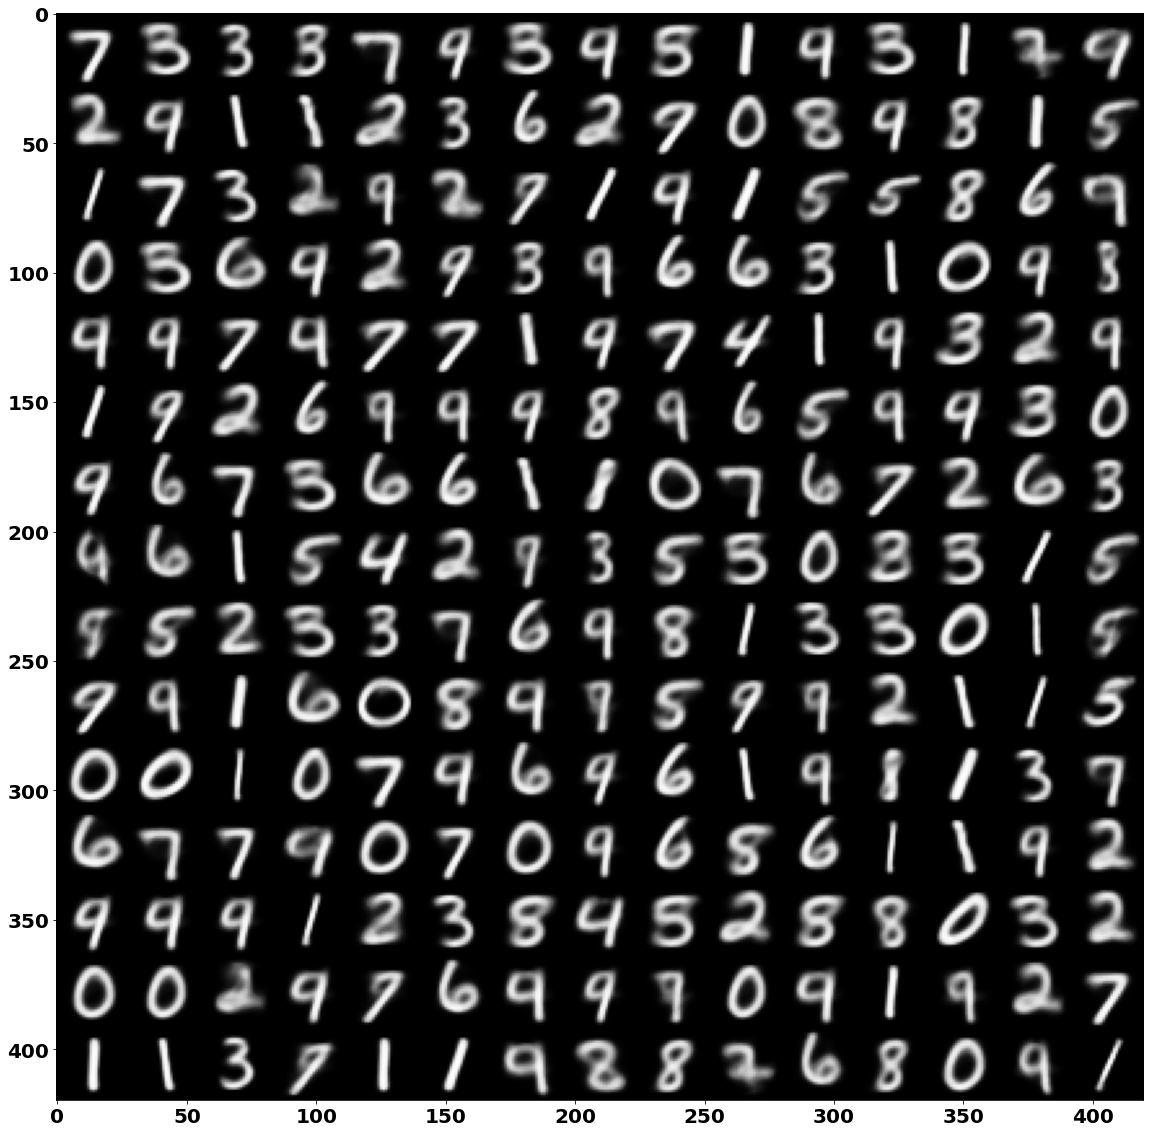

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


INFO:tensorflow:Assets written to: gdrive/My Drive/Colab Notebooks/coupled_vae/output/v3.2.1/seed0/model/cvae_cd1e-06_cl1e-06/assets


INFO:tensorflow:Assets written to: gdrive/My Drive/Colab Notebooks/coupled_vae/output/v3.2.1/seed0/model/cvae_cd1e-06_cl1e-06/assets


Decisiveness (Arithmetic Mean): 1.1563016169557905e-16
Accuracy (Geometric Mean): 2.3735388777971887e-58
Robustness (-2/3 Mean): 2.6874683176667127e-238
1.1563016169557904789e-16 2.3735388777971887e-58 2.6874683176667128177e-238
Run time: 18.52 min

Decisiveness (Arithmetic Mean): 3.9871534893154426e-16
Accuracy (Geometric Mean): 1.8854755941995856e-55
Robustness (-2/3 Mean): 3.562004305556416e-216
Displaying Coupled VAE: coupling distribution = 1e-06, coupling loss = 0.025, seed = 0
2
[[ 0.26955366  0.6445884 ]
 [-0.5411113  -0.5985159 ]
 [-0.9453504   1.4388602 ]
 ...
 [-0.12140864  0.7966501 ]
 [ 0.7169218   1.509742  ]
 [ 0.588237   -0.895182  ]]


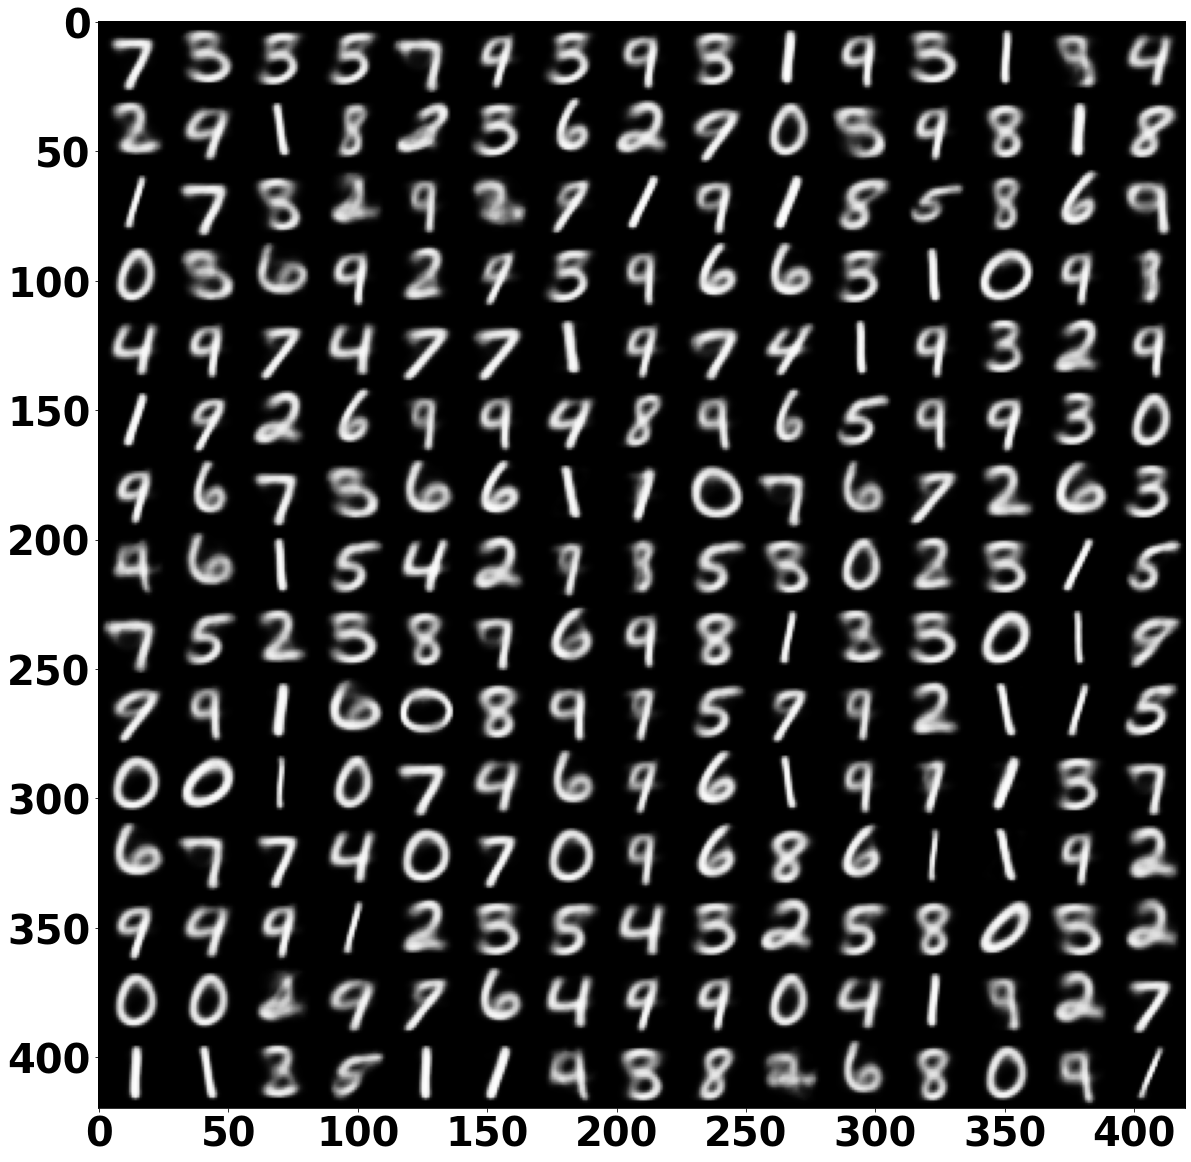

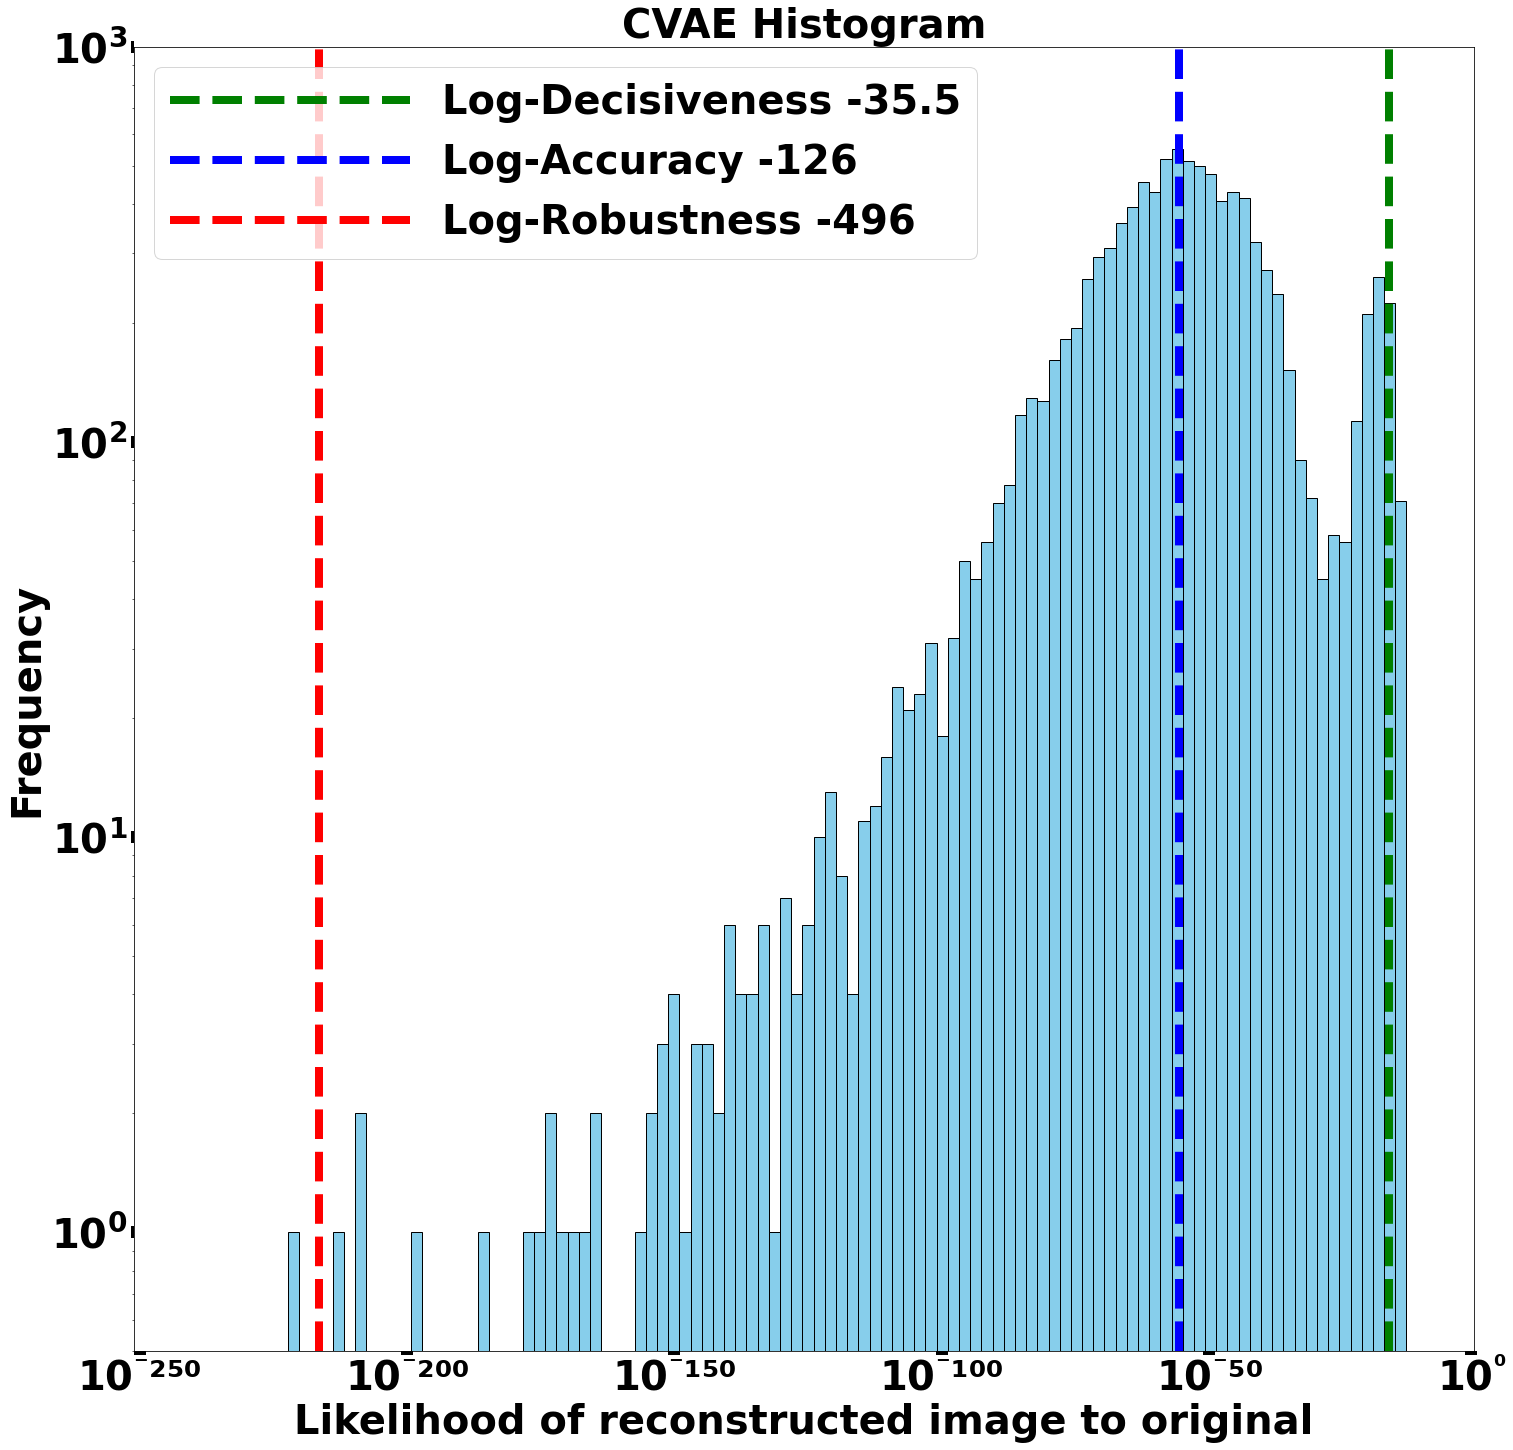

INFO:tensorflow:Assets written to: gdrive/My Drive/Colab Notebooks/coupled_vae/output/v3.2.1/seed0/model/cvae_cd1e-06_cl0.025/assets


INFO:tensorflow:Assets written to: gdrive/My Drive/Colab Notebooks/coupled_vae/output/v3.2.1/seed0/model/cvae_cd1e-06_cl0.025/assets


Decisiveness (Arithmetic Mean): 3.9871534893154426e-16
Accuracy (Geometric Mean): 1.8854755941995856e-55
Robustness (-2/3 Mean): 3.562004305556416e-216
3.987153489315442556e-16 1.8854755941995856e-55 3.5620043055564155313e-216
Run time: 18.29 min

Decisiveness (Arithmetic Mean): 2.8447296601674665e-15
Accuracy (Geometric Mean): 8.738413604637091e-53
Robustness (-2/3 Mean): 1.1833111996834157e-210
Displaying Coupled VAE: coupling distribution = 1e-06, coupling loss = 0.05, seed = 0
2
[[ 0.3842117   0.57923245]
 [-0.6112398  -0.46458027]
 [-0.88286495  1.4132907 ]
 ...
 [-0.03677587  0.7356913 ]
 [ 0.6363152   1.4627876 ]
 [ 0.58001655 -0.8526609 ]]


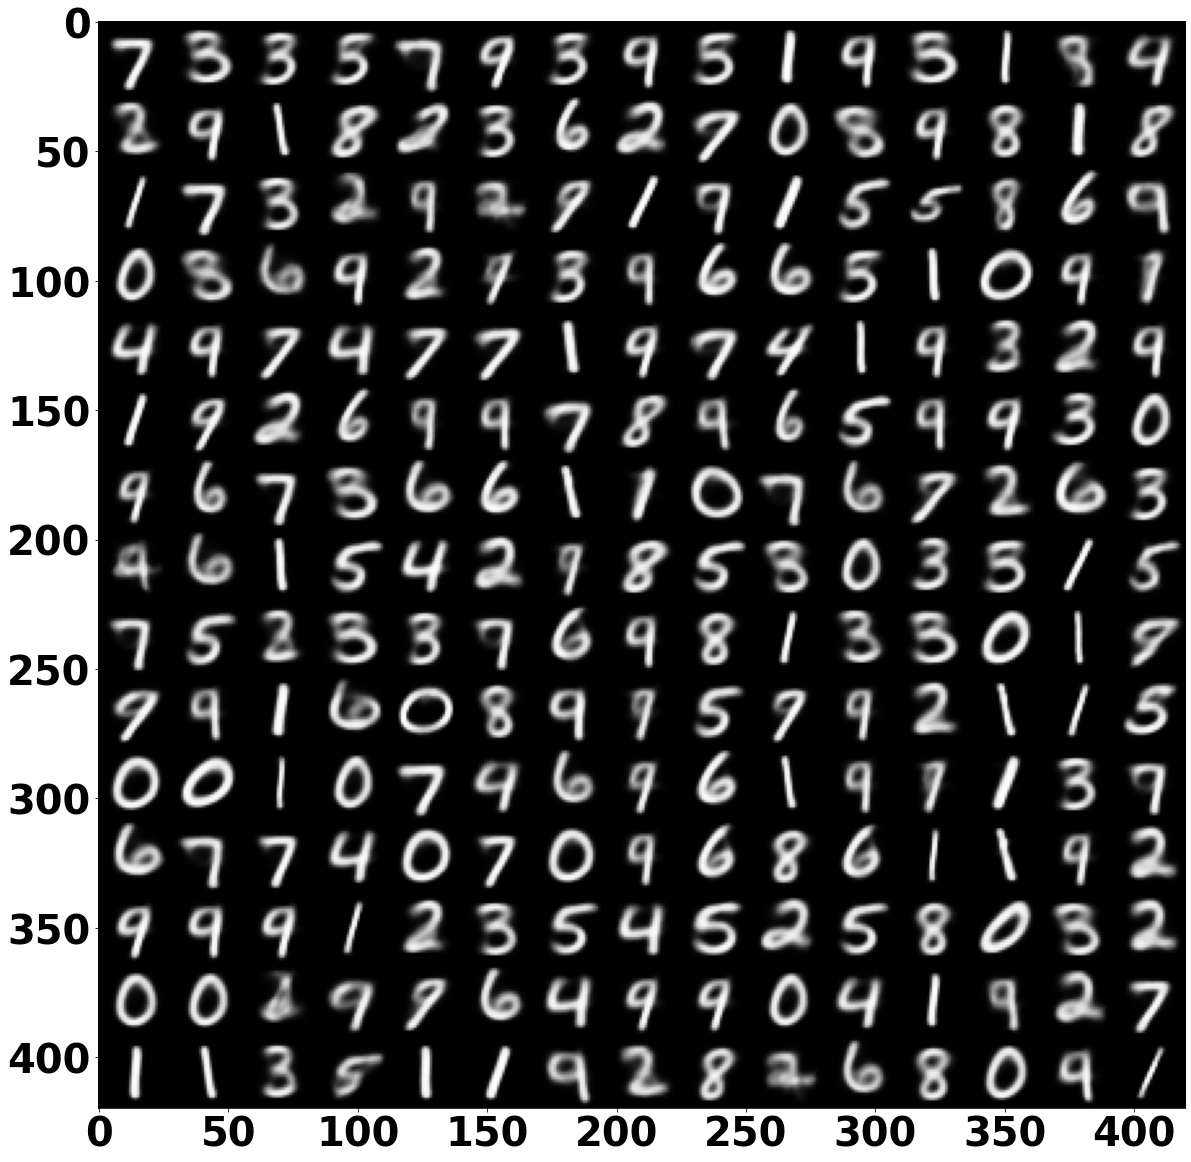

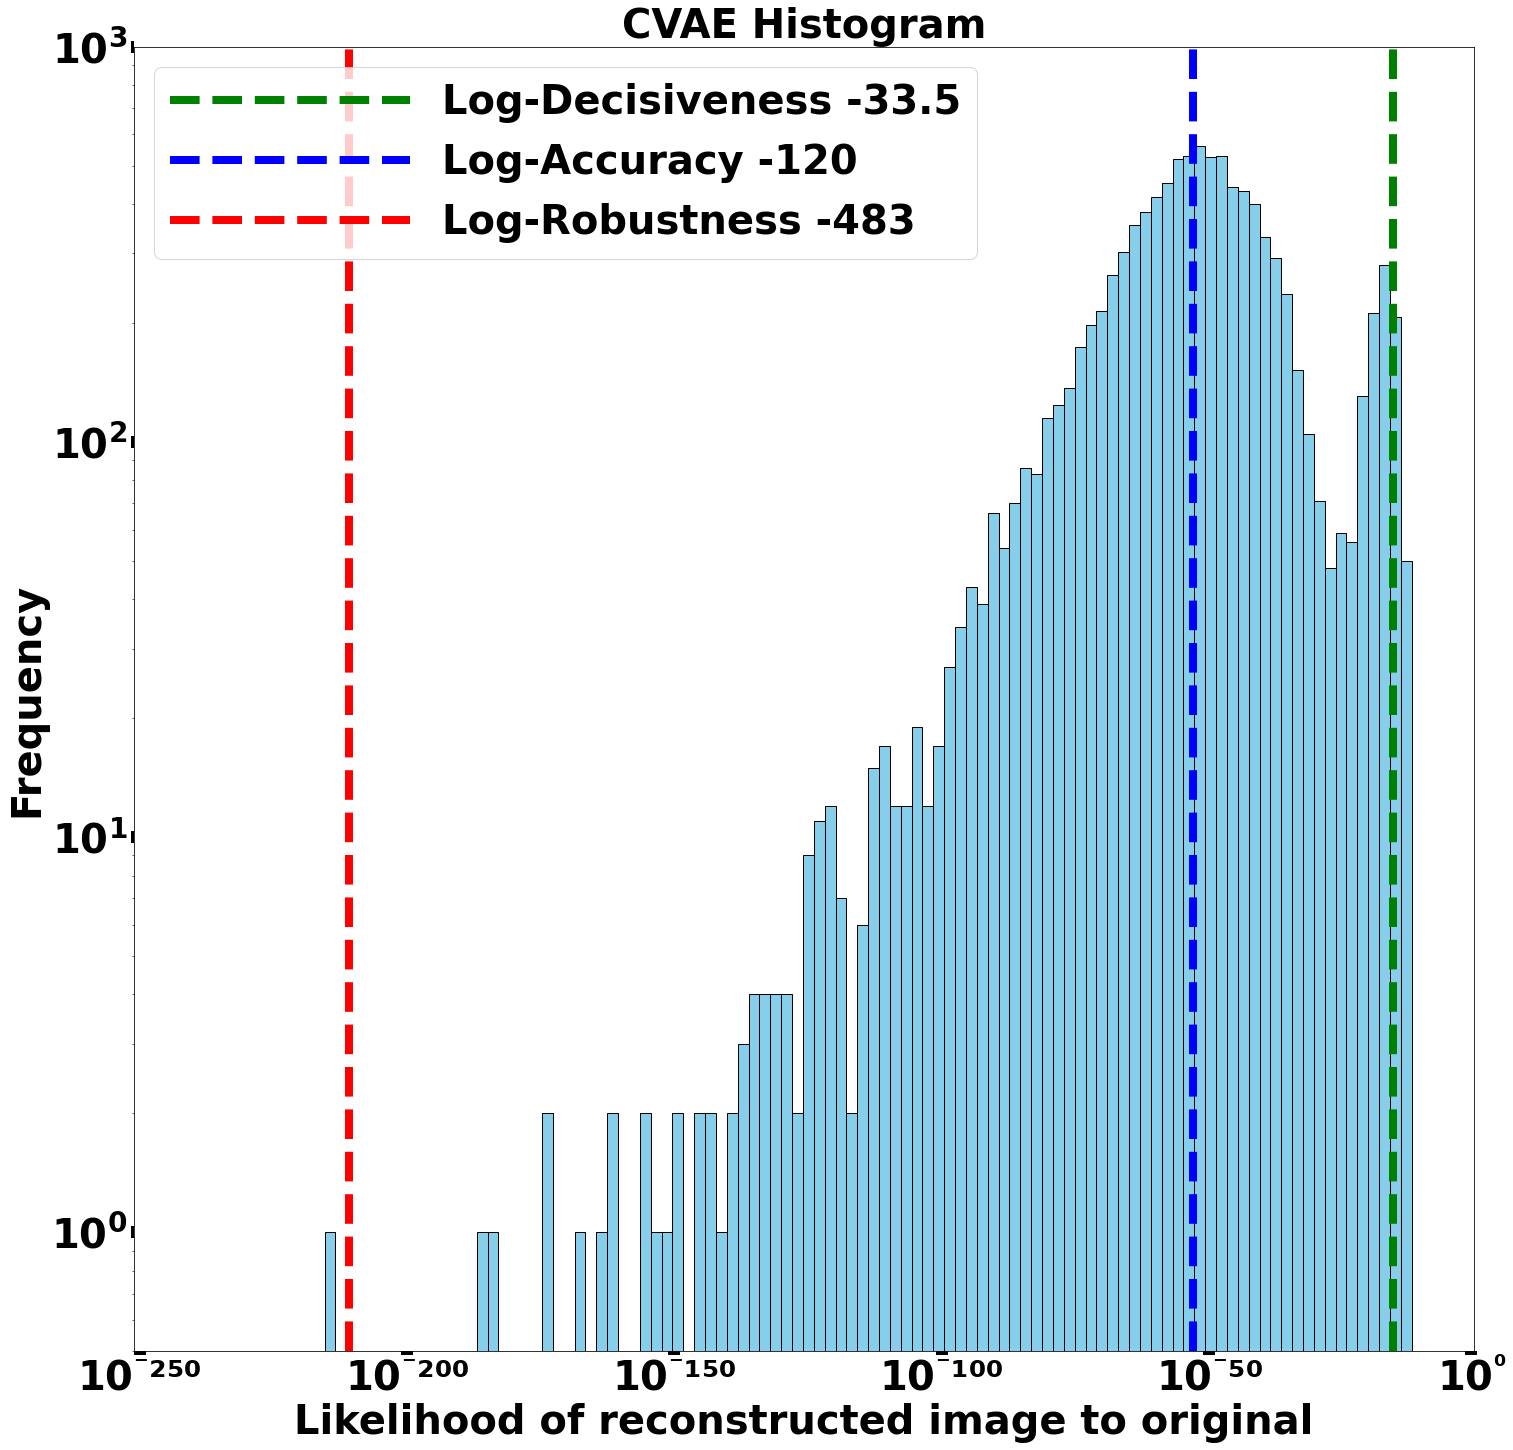

INFO:tensorflow:Assets written to: gdrive/My Drive/Colab Notebooks/coupled_vae/output/v3.2.1/seed0/model/cvae_cd1e-06_cl0.05/assets


INFO:tensorflow:Assets written to: gdrive/My Drive/Colab Notebooks/coupled_vae/output/v3.2.1/seed0/model/cvae_cd1e-06_cl0.05/assets


Decisiveness (Arithmetic Mean): 2.8447296601674665e-15
Accuracy (Geometric Mean): 8.738413604637091e-53
Robustness (-2/3 Mean): 1.1833111996834157e-210
2.844729660167466534e-15 8.738413604637091e-53 1.1833111996834157516e-210
Run time: 18.06 min

Decisiveness (Arithmetic Mean): 1.011538942885526e-14
Accuracy (Geometric Mean): 3.584952339441109e-50
Robustness (-2/3 Mean): 4.625922876590714e-174
Displaying Coupled VAE: coupling distribution = 1e-06, coupling loss = 0.075, seed = 0
2
[[ 0.2420477   0.56962854]
 [-0.5052355  -0.43839514]
 [-0.5900207   1.3300784 ]
 ...
 [-0.089601    0.78131896]
 [ 1.1031787   1.2479038 ]
 [ 0.64707553 -0.7772463 ]]


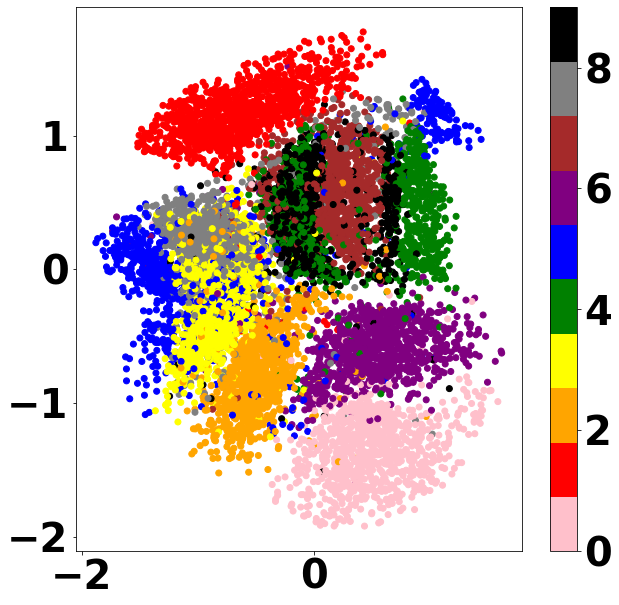

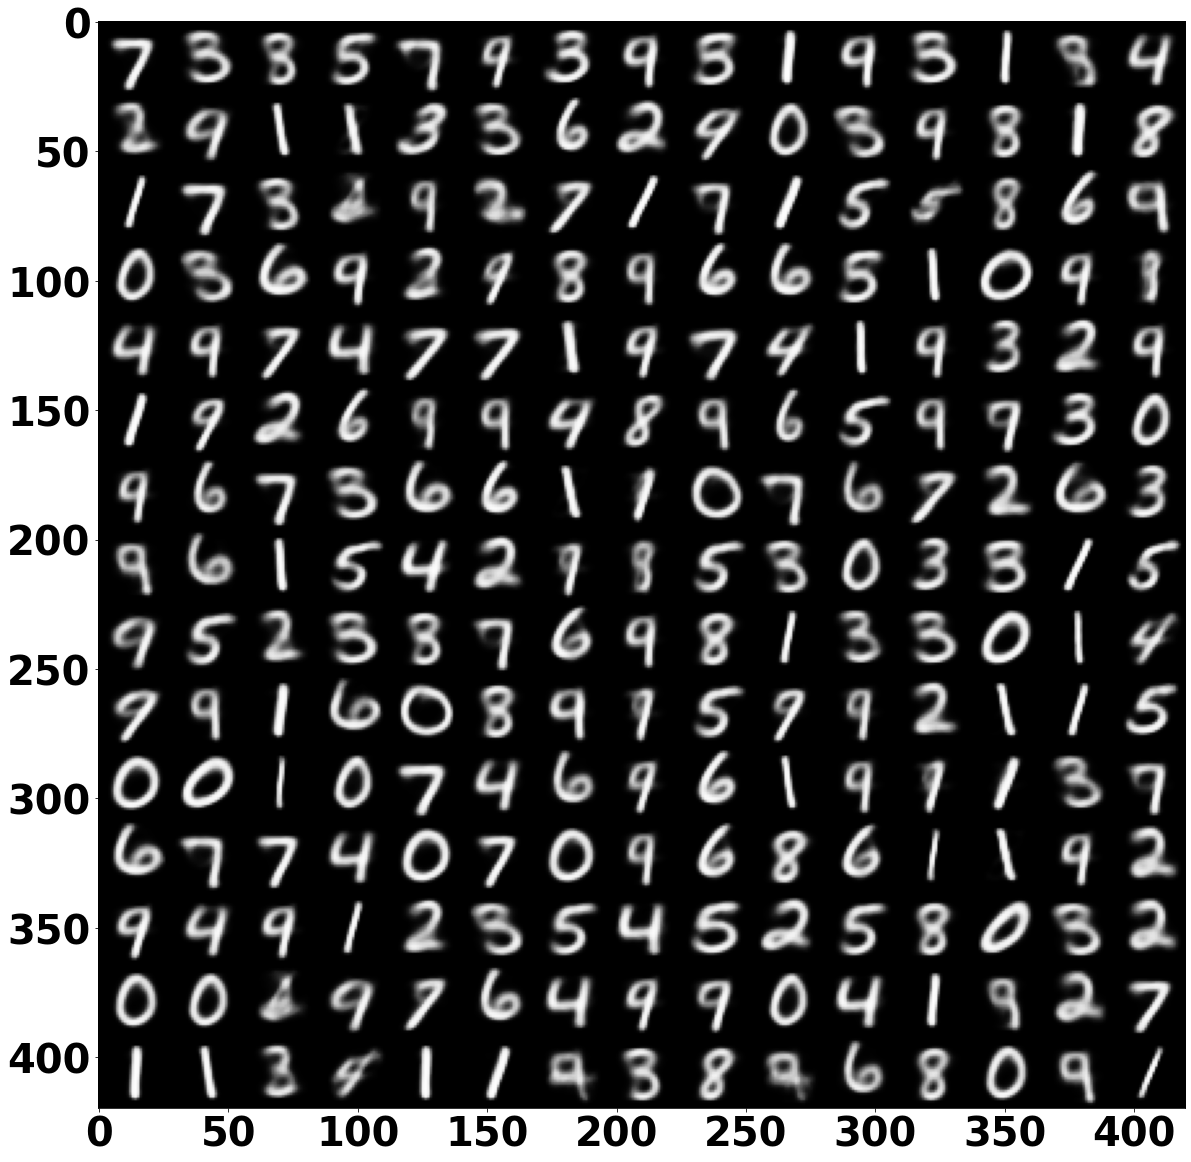

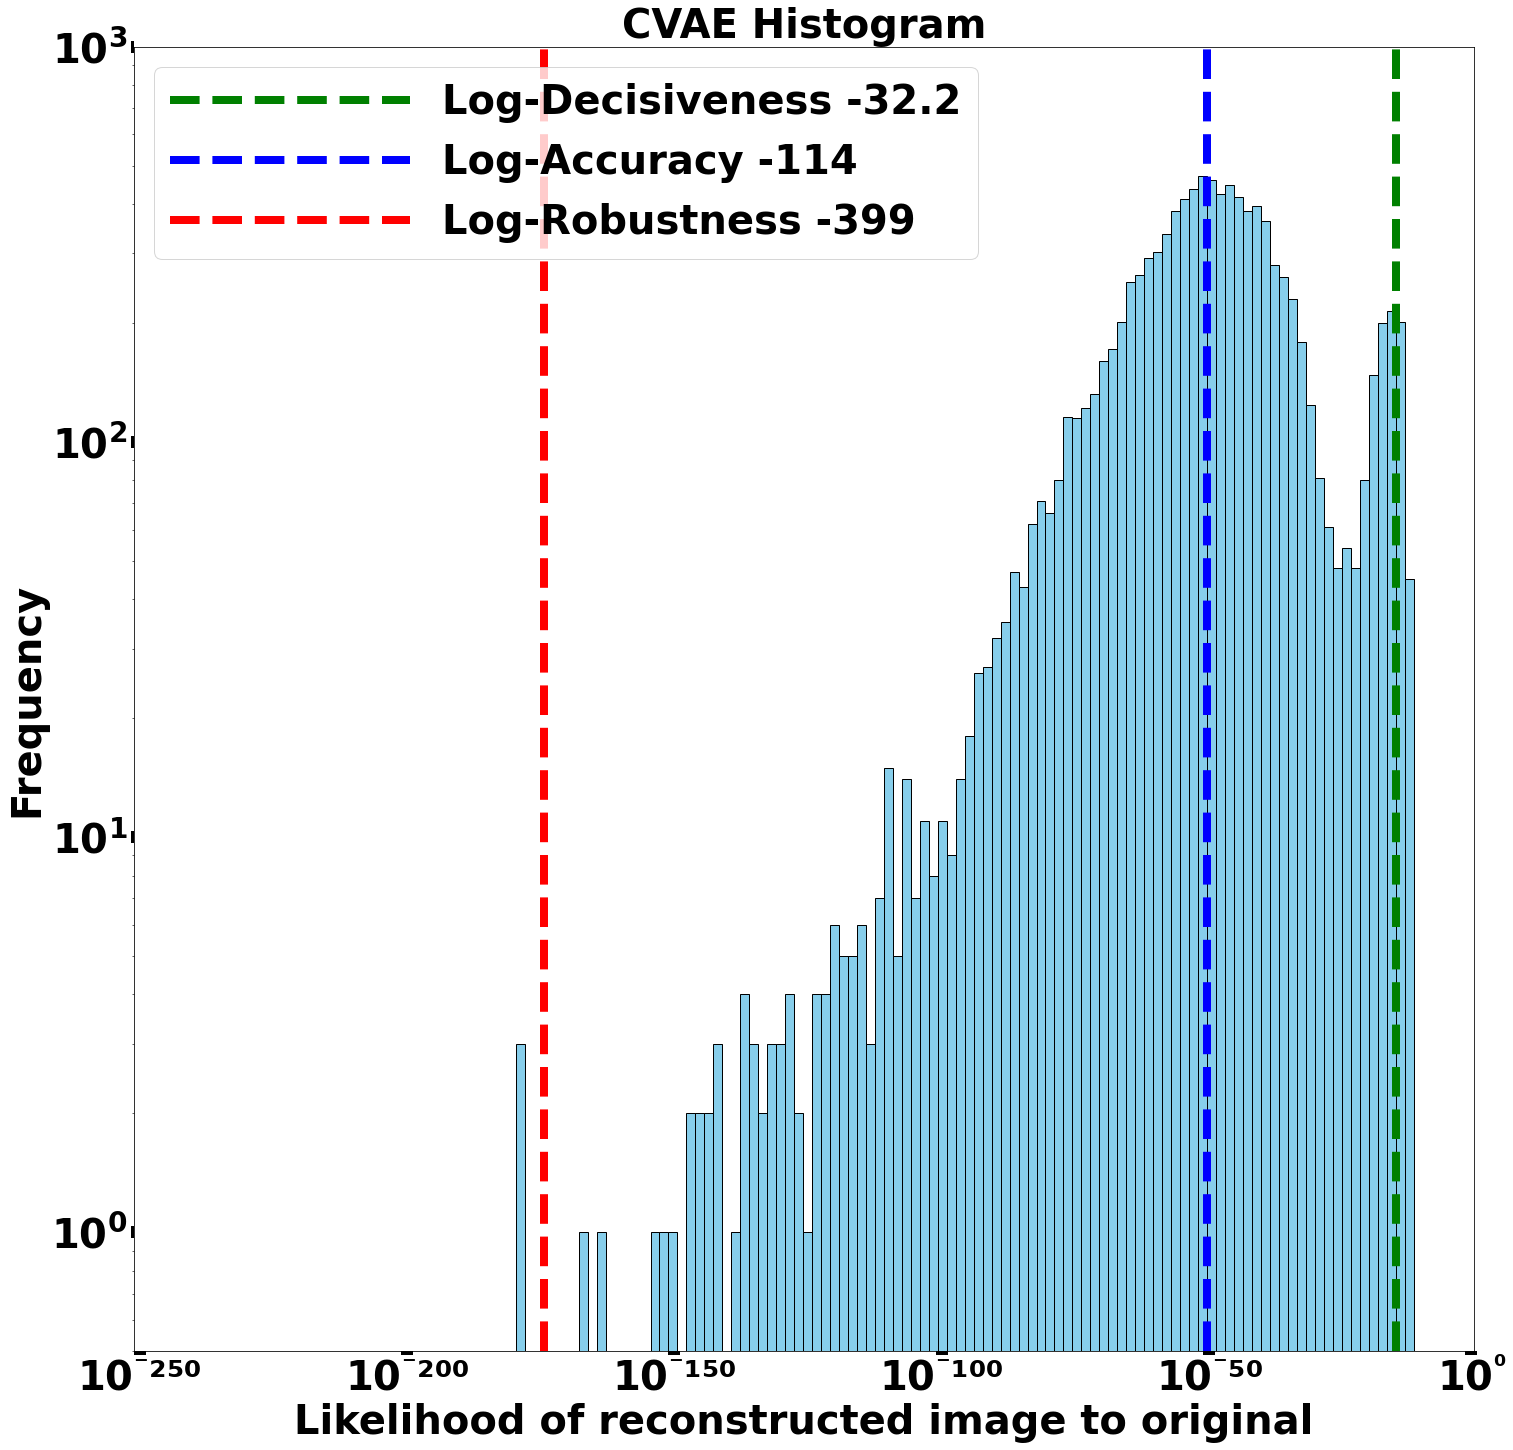

INFO:tensorflow:Assets written to: gdrive/My Drive/Colab Notebooks/coupled_vae/output/v3.2.1/seed0/model/cvae_cd1e-06_cl0.075/assets


INFO:tensorflow:Assets written to: gdrive/My Drive/Colab Notebooks/coupled_vae/output/v3.2.1/seed0/model/cvae_cd1e-06_cl0.075/assets


Decisiveness (Arithmetic Mean): 1.011538942885526e-14
Accuracy (Geometric Mean): 3.584952339441109e-50
Robustness (-2/3 Mean): 4.625922876590714e-174
1.01153894288552592684e-14 3.584952339441109e-50 4.625922876590713836e-174
Run time: 18.11 min

Decisiveness (Arithmetic Mean): 5.577510025014942e-14
Accuracy (Geometric Mean): 8.158853035825793e-48
Robustness (-2/3 Mean): 2.34303597567451e-190
Displaying Coupled VAE: coupling distribution = 1e-06, coupling loss = 0.1, seed = 0
2
[[ 0.48573568  0.8607303 ]
 [-0.2137467  -0.38951534]
 [-1.0773273   1.1244639 ]
 ...
 [ 0.15515696  1.0586408 ]
 [-1.4093144  -0.03549476]
 [ 0.34759578 -0.7984767 ]]


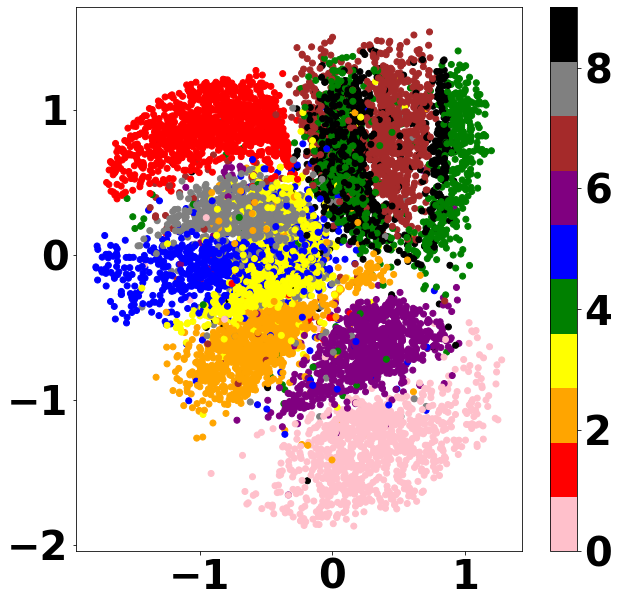

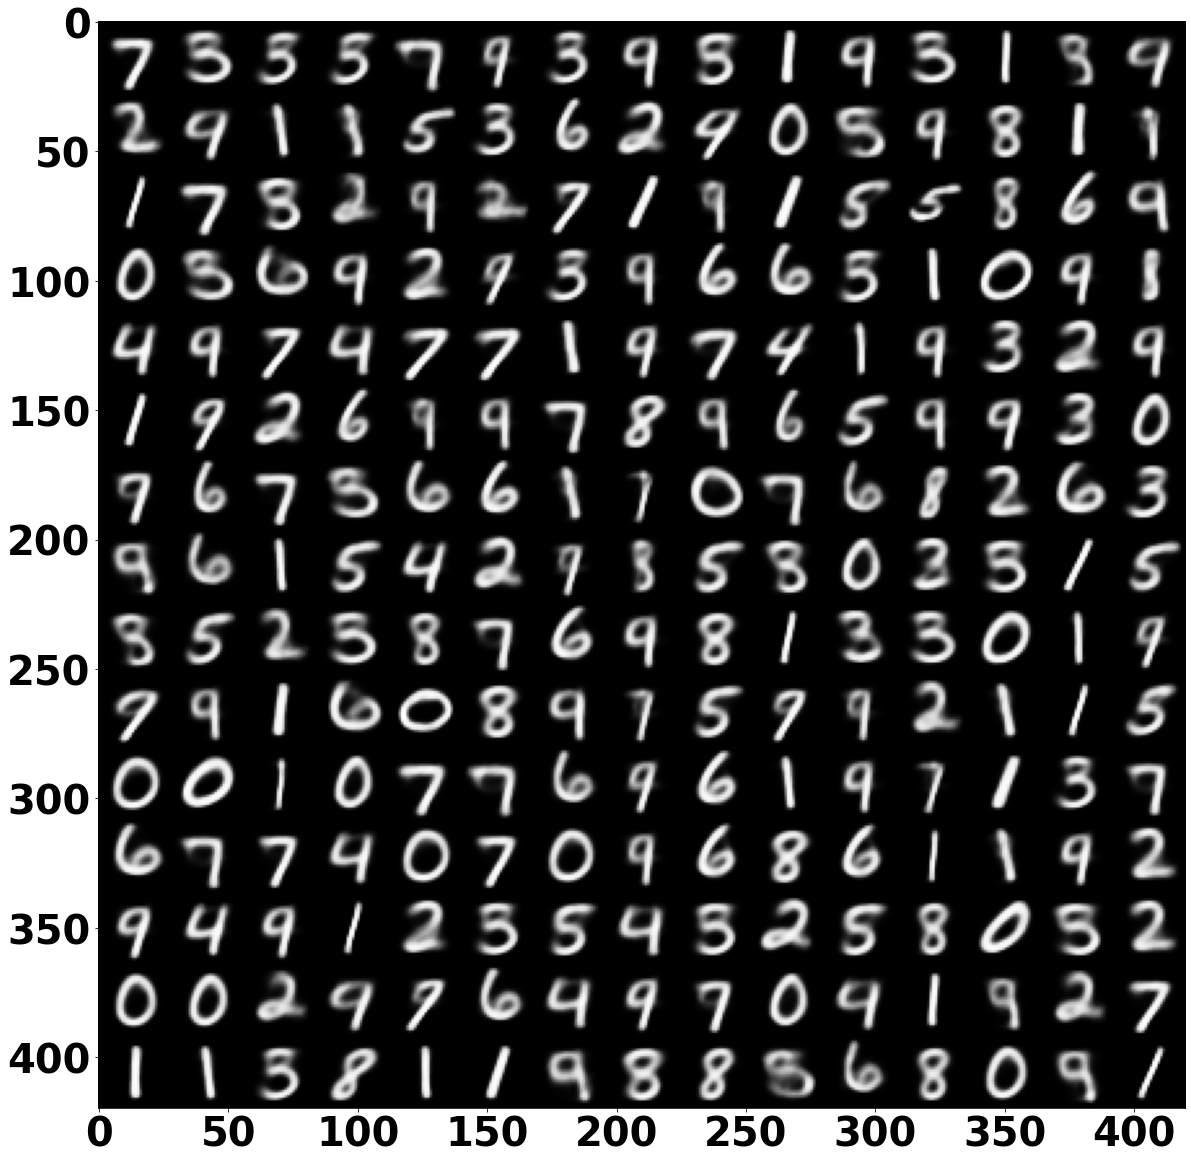

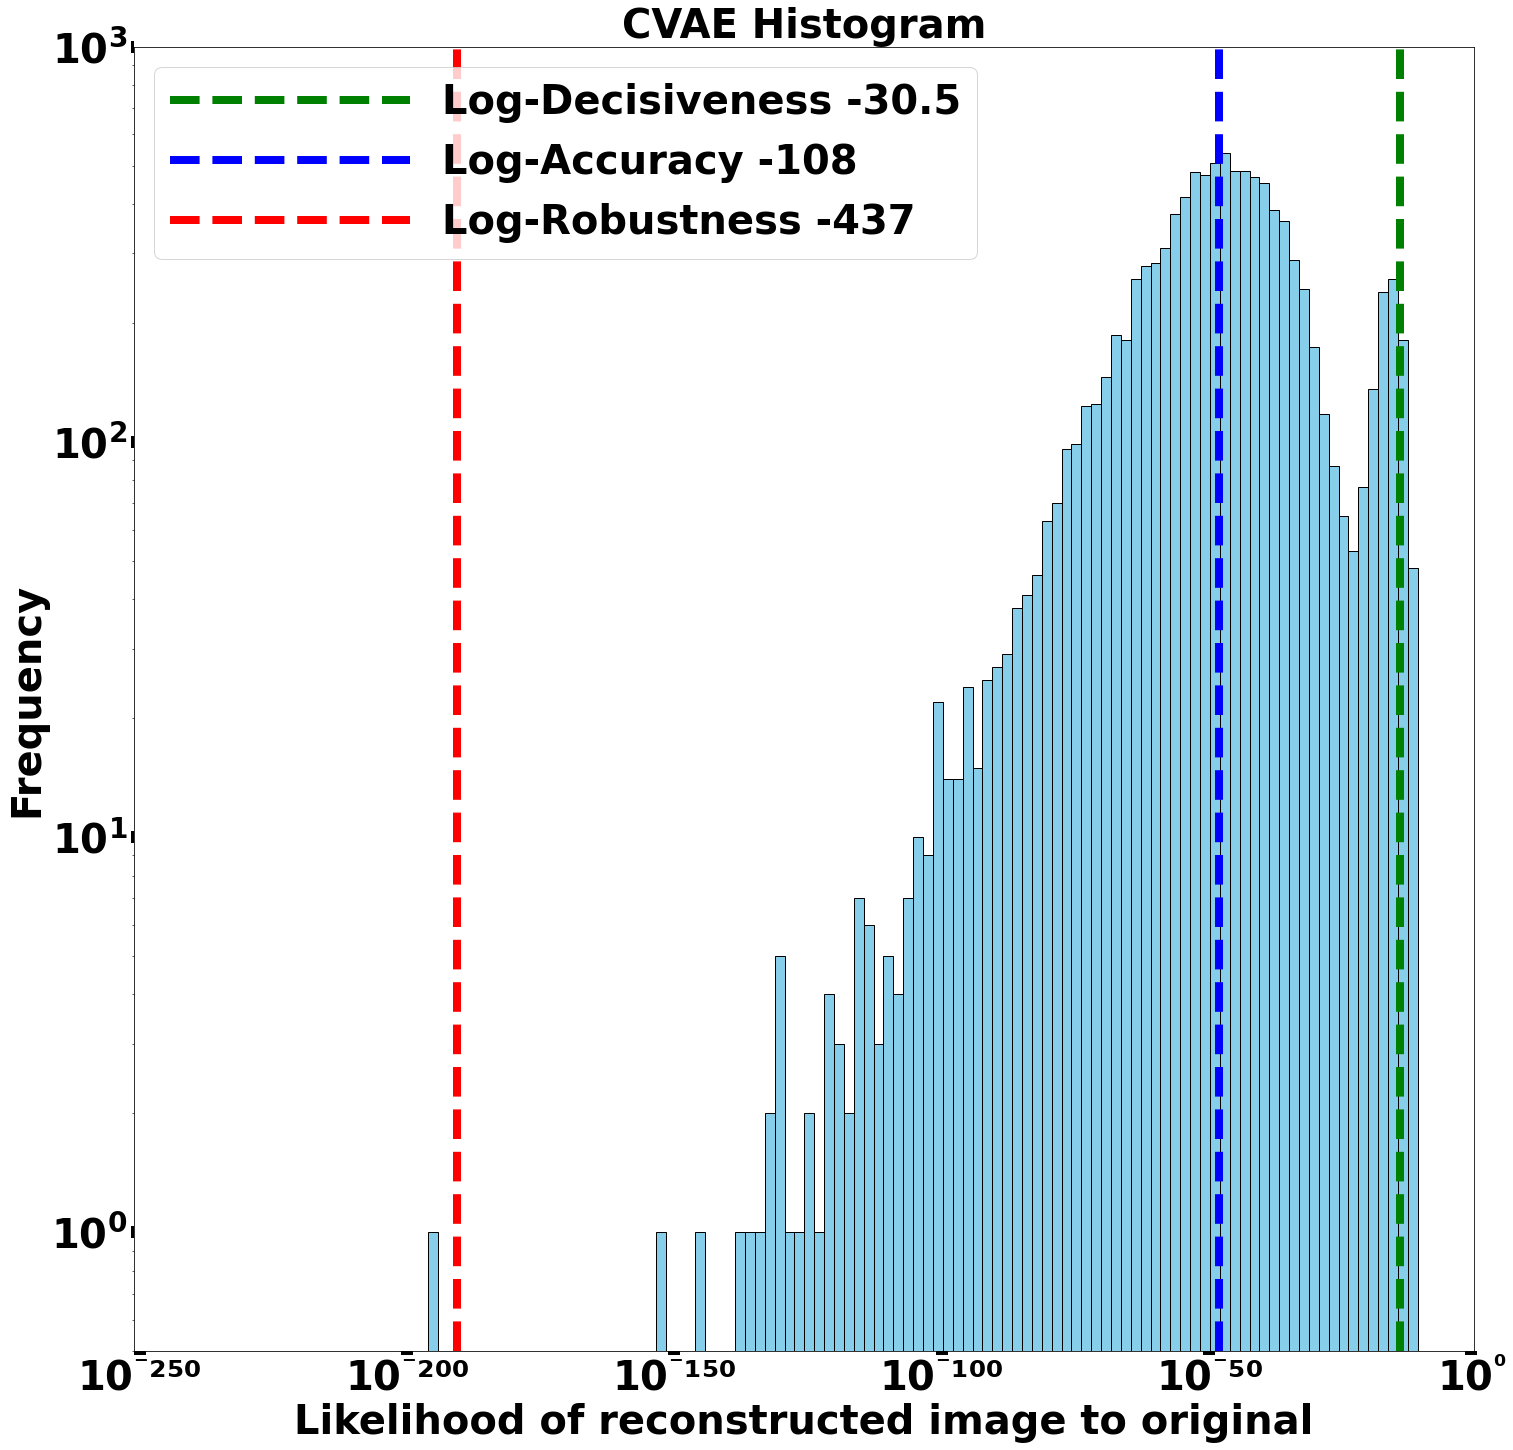

INFO:tensorflow:Assets written to: gdrive/My Drive/Colab Notebooks/coupled_vae/output/v3.2.1/seed0/model/cvae_cd1e-06_cl0.1/assets


INFO:tensorflow:Assets written to: gdrive/My Drive/Colab Notebooks/coupled_vae/output/v3.2.1/seed0/model/cvae_cd1e-06_cl0.1/assets


Decisiveness (Arithmetic Mean): 5.577510025014942e-14
Accuracy (Geometric Mean): 8.158853035825793e-48
Robustness (-2/3 Mean): 2.34303597567451e-190
5.5775100250149423076e-14 8.158853035825793e-48 2.3430359756745097184e-190
Run time: 18.29 min

Decisiveness (Arithmetic Mean): 1.505318764603858e-13
Accuracy (Geometric Mean): 6.2059396797615e-46
Robustness (-2/3 Mean): 5.960893392928016e-162
Displaying Coupled VAE: coupling distribution = 1e-06, coupling loss = 0.125, seed = 0
2
[[ 0.35034856  0.5026014 ]
 [-0.61222553 -0.29560828]
 [-0.41787276  1.2350305 ]
 ...
 [ 0.0475824   0.7168693 ]
 [ 0.88453114  1.0556517 ]
 [ 0.56671494 -0.73977363]]


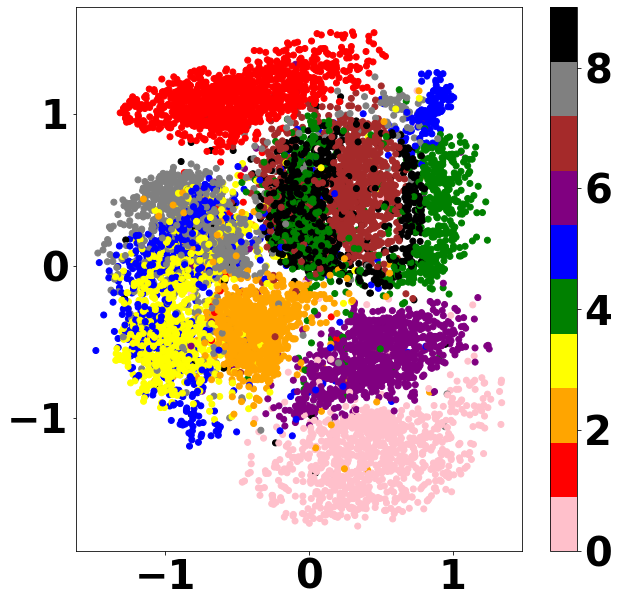

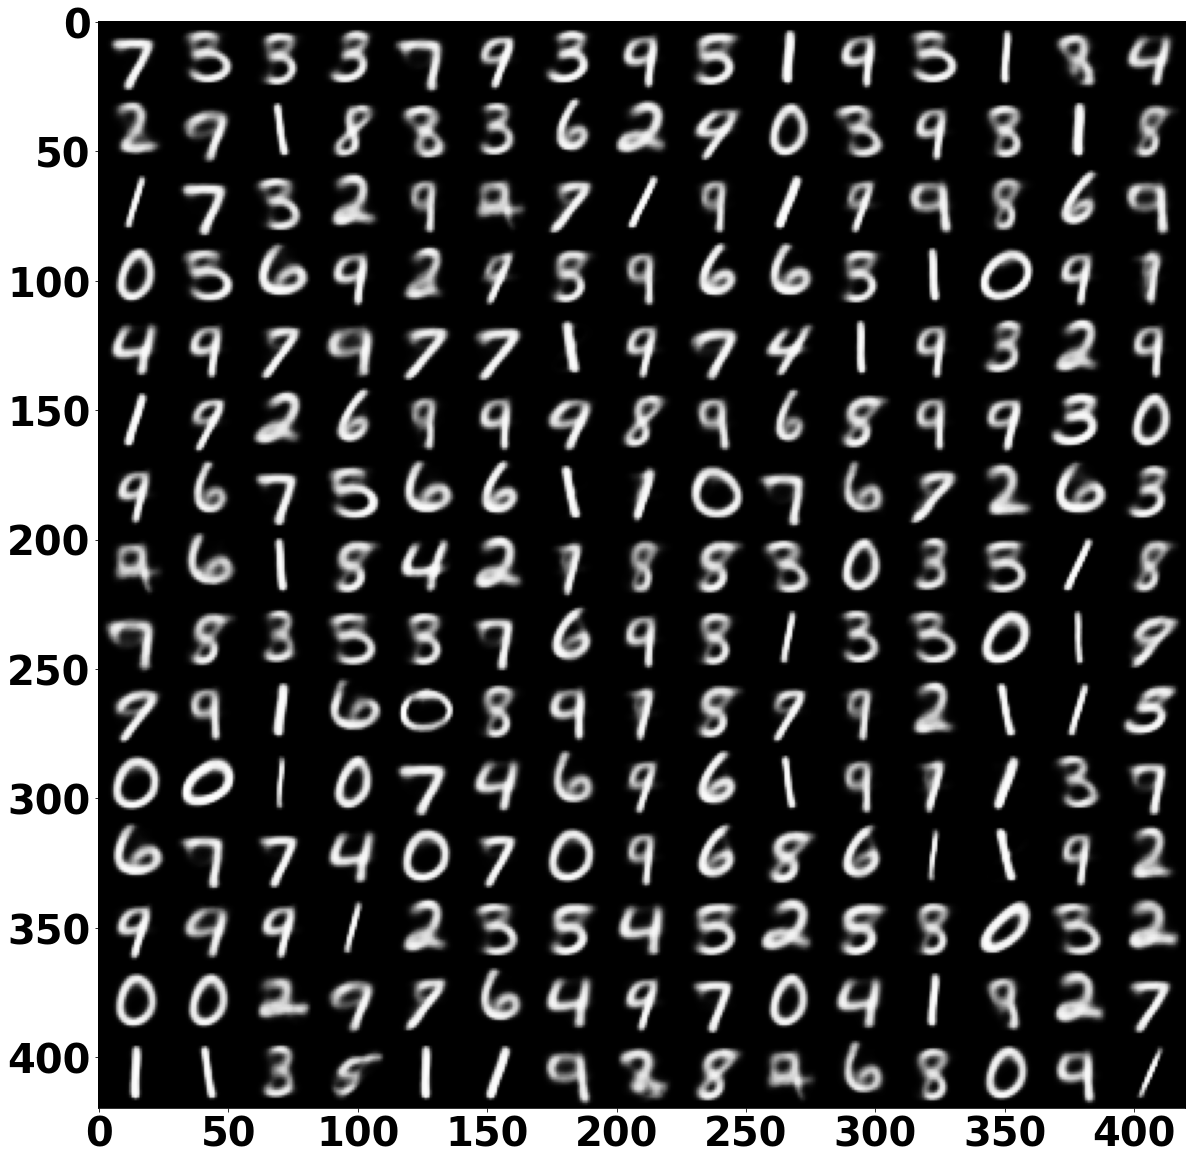

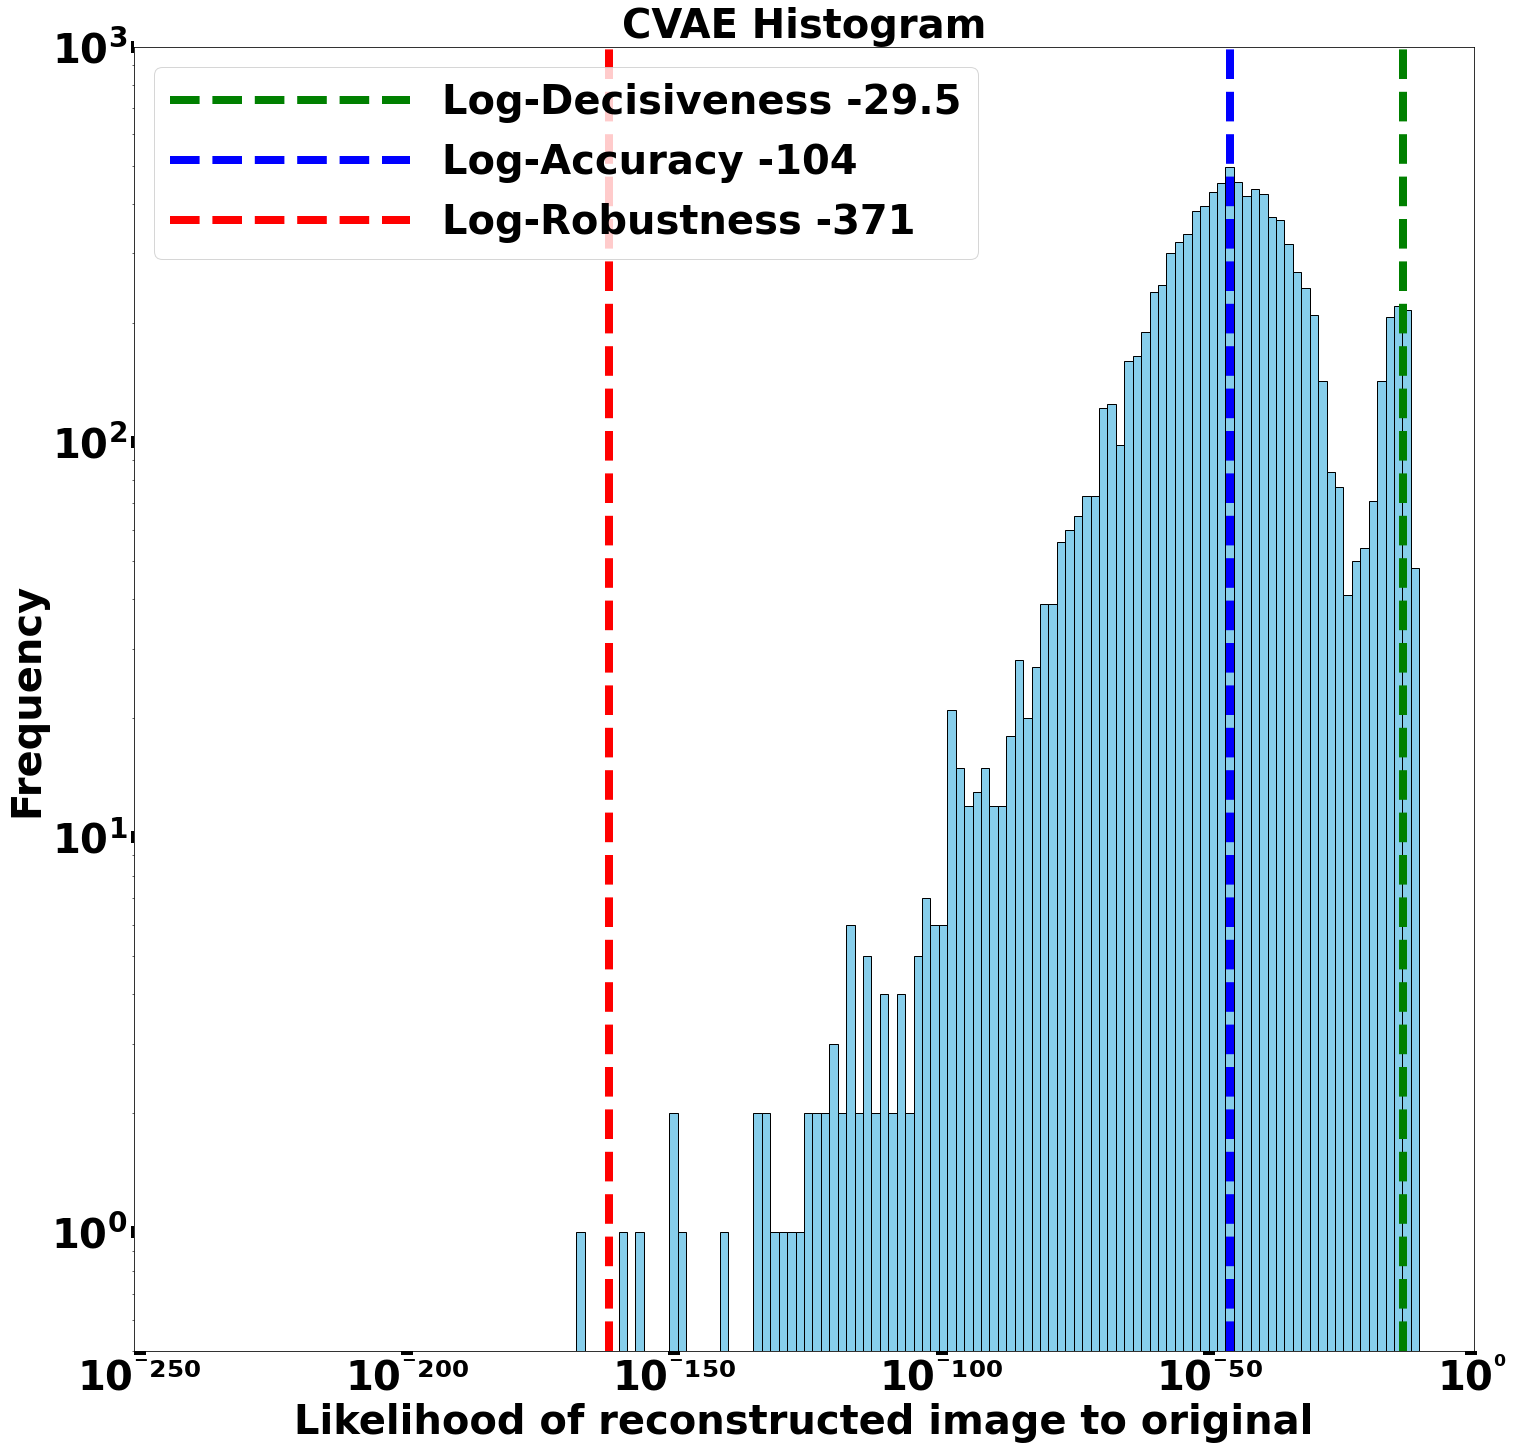

INFO:tensorflow:Assets written to: gdrive/My Drive/Colab Notebooks/coupled_vae/output/v3.2.1/seed0/model/cvae_cd1e-06_cl0.125/assets


INFO:tensorflow:Assets written to: gdrive/My Drive/Colab Notebooks/coupled_vae/output/v3.2.1/seed0/model/cvae_cd1e-06_cl0.125/assets


Decisiveness (Arithmetic Mean): 1.505318764603858e-13
Accuracy (Geometric Mean): 6.2059396797615e-46
Robustness (-2/3 Mean): 5.960893392928016e-162
1.5053187646038579395e-13 6.2059396797615e-46 5.9608933929280160653e-162
Run time: 18.32 min

Decisiveness (Arithmetic Mean): 6.932597399790519e-13
Accuracy (Geometric Mean): 5.864106184193395e-44
Robustness (-2/3 Mean): 5.2626330723055e-158
Displaying Coupled VAE: coupling distribution = 1e-06, coupling loss = 0.15, seed = 0
2
[[ 0.35052148  0.45901403]
 [-0.5222251  -0.30155984]
 [-0.36668074  1.1956314 ]
 ...
 [ 0.07929778  0.68872184]
 [ 0.8451516   0.9893736 ]
 [ 0.19363037 -0.76573855]]


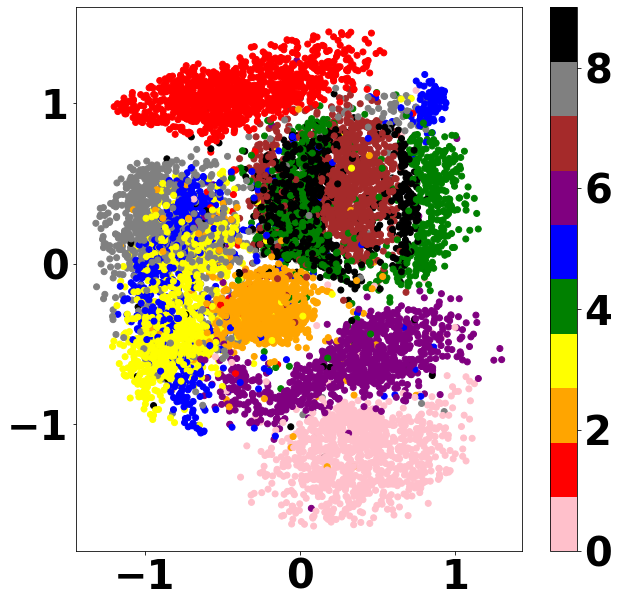

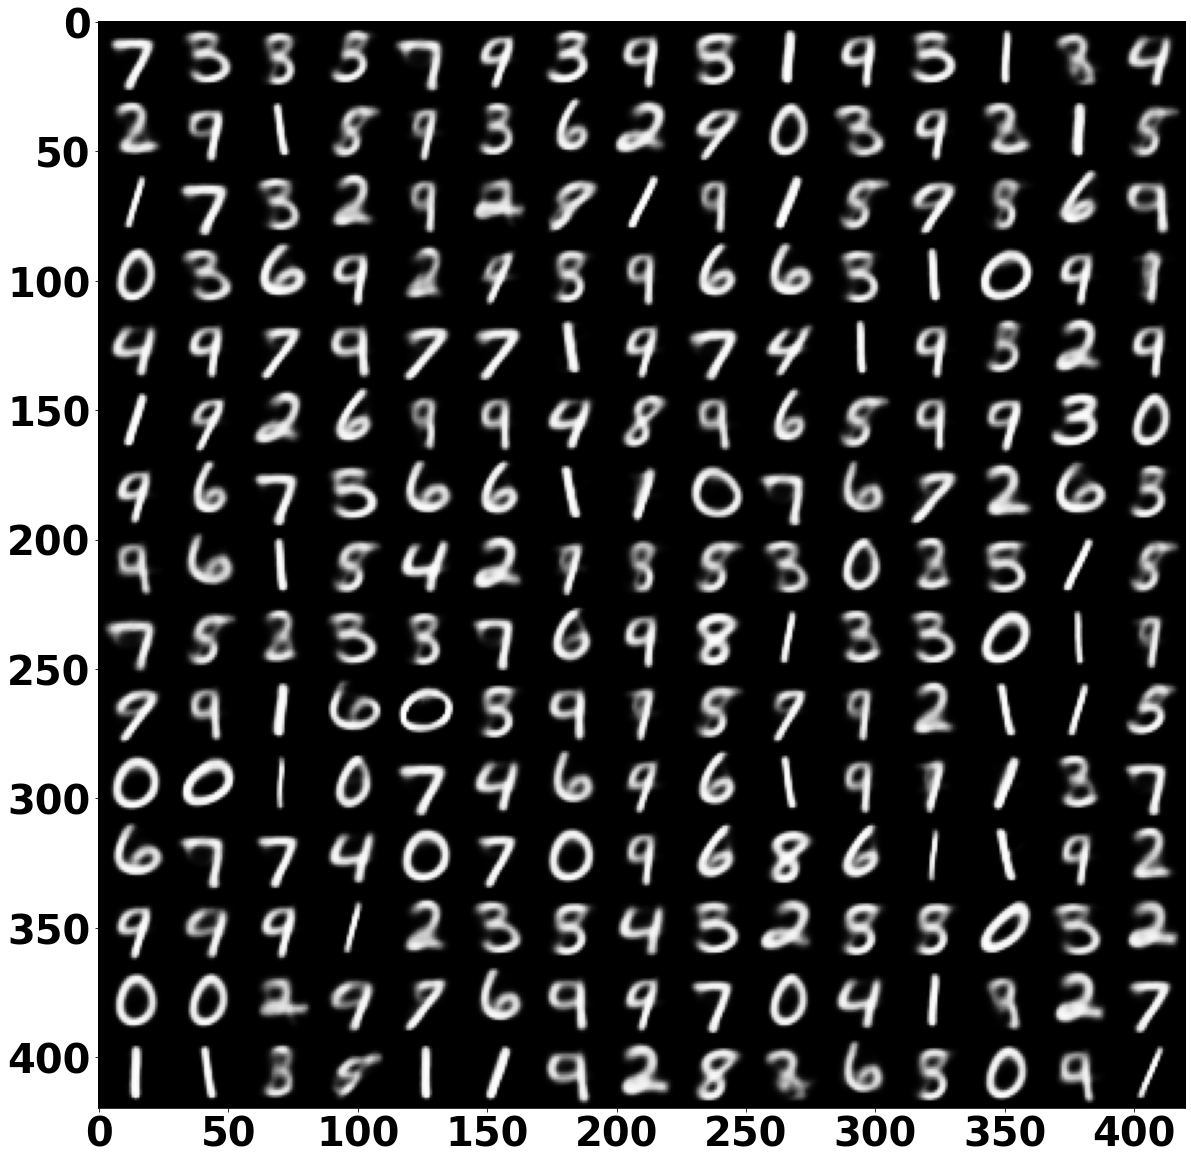

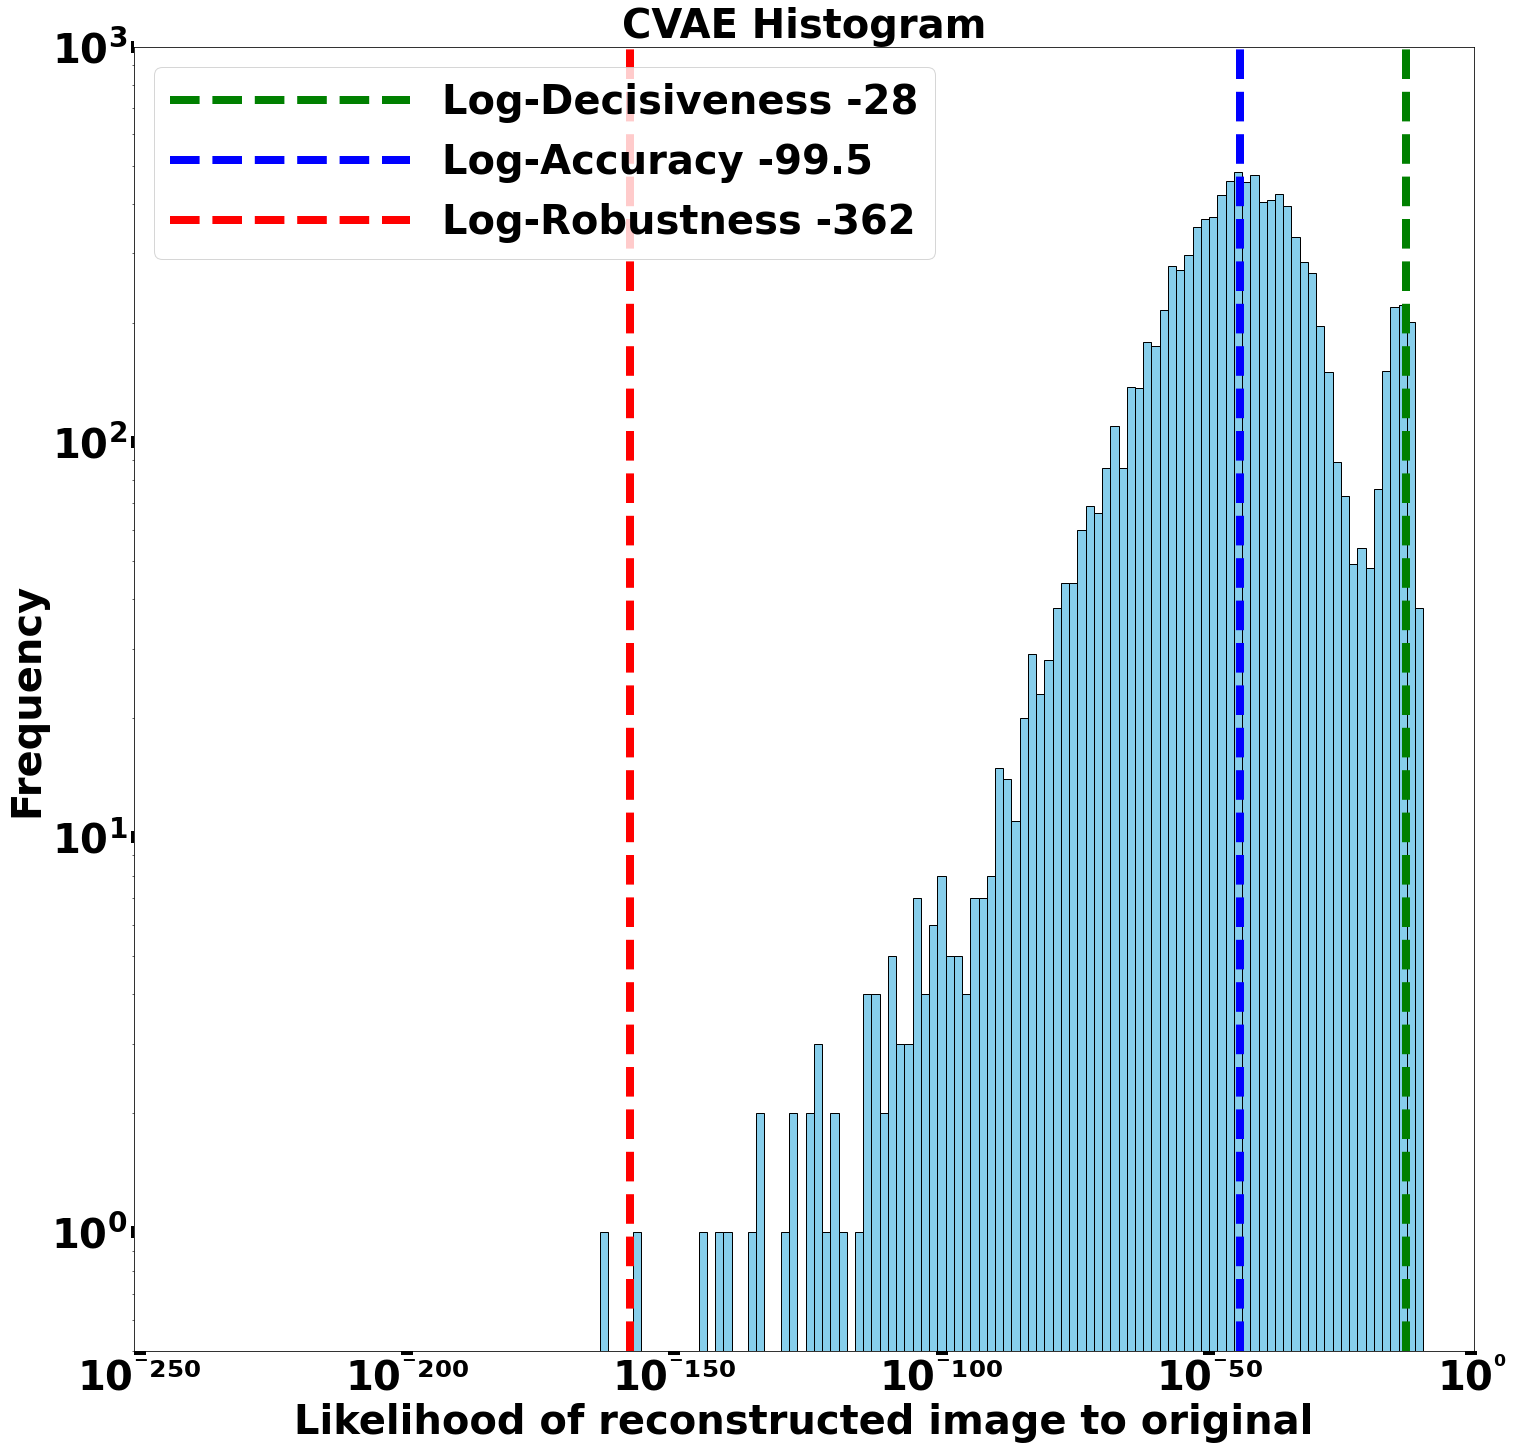

INFO:tensorflow:Assets written to: gdrive/My Drive/Colab Notebooks/coupled_vae/output/v3.2.1/seed0/model/cvae_cd1e-06_cl0.15/assets


INFO:tensorflow:Assets written to: gdrive/My Drive/Colab Notebooks/coupled_vae/output/v3.2.1/seed0/model/cvae_cd1e-06_cl0.15/assets


Decisiveness (Arithmetic Mean): 6.932597399790519e-13
Accuracy (Geometric Mean): 5.864106184193395e-44
Robustness (-2/3 Mean): 5.2626330723055e-158
6.9325973997905188106e-13 5.864106184193395e-44 5.2626330723054997893e-158
Run time: 17.85 min

Decisiveness (Arithmetic Mean): 0.0
Accuracy (Geometric Mean): 0.0
Robustness (-2/3 Mean): 0.0
Displaying Coupled VAE: coupling distribution = 1e-06, coupling loss = 0.175, seed = 0
2
[[nan nan]
 [nan nan]
 [nan nan]
 ...
 [nan nan]
 [nan nan]
 [nan nan]]


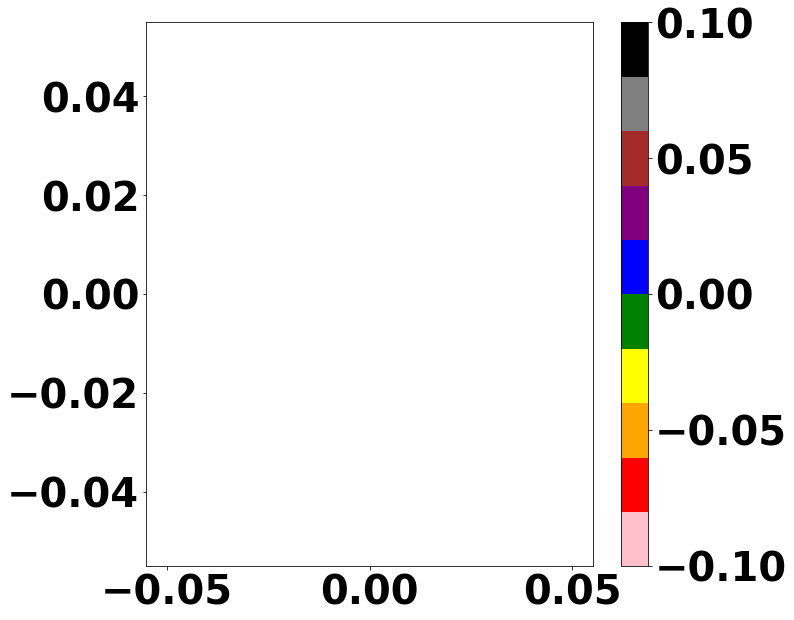

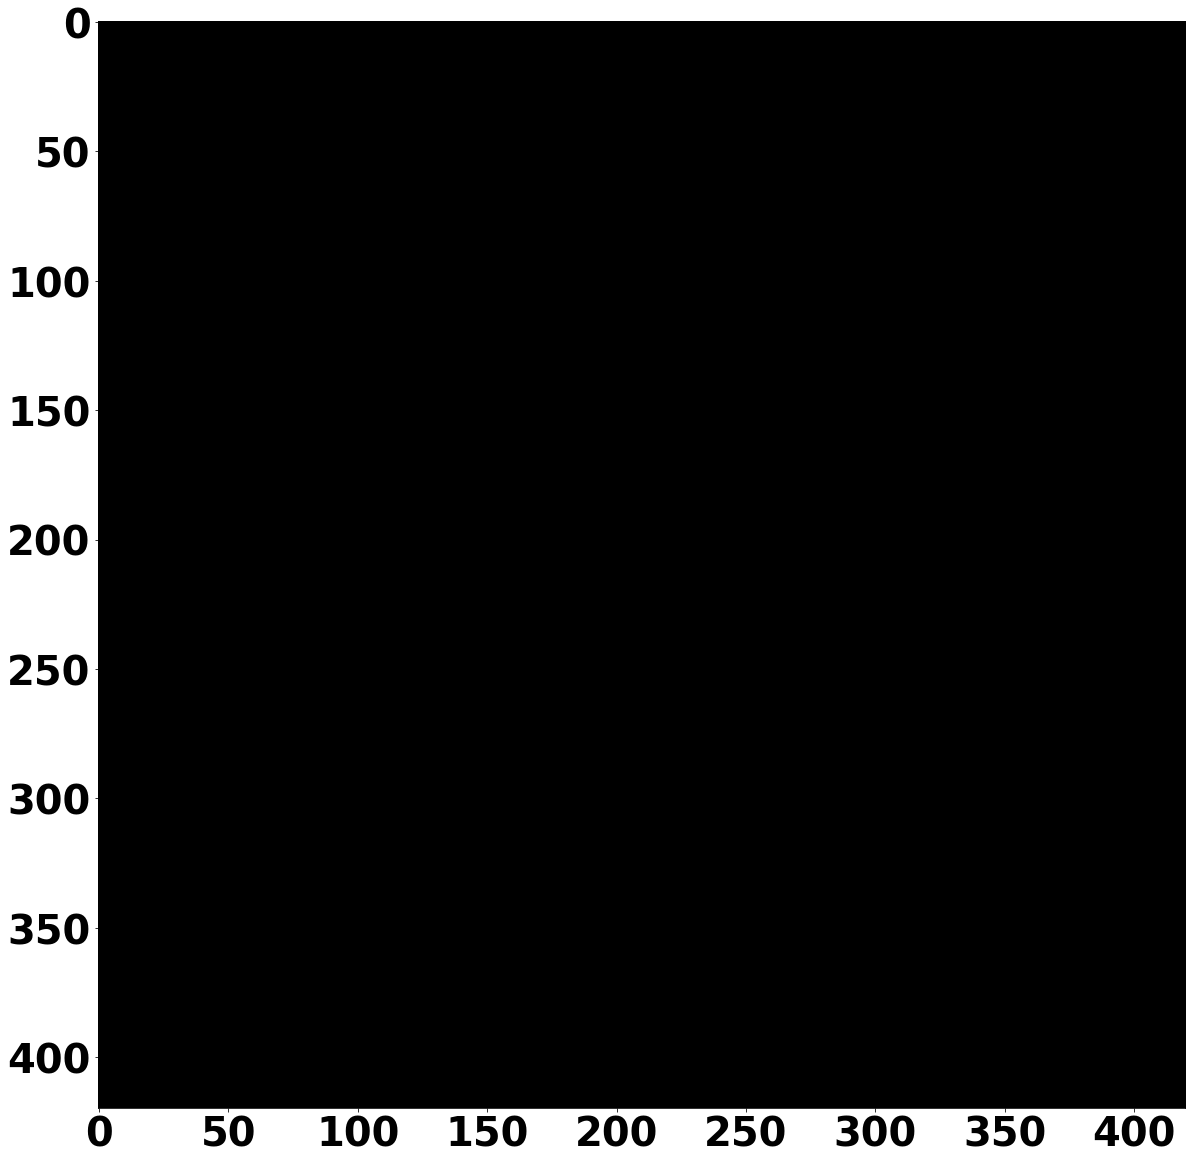

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:235: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:236: RuntimeWarning: divide by zero encountered in log


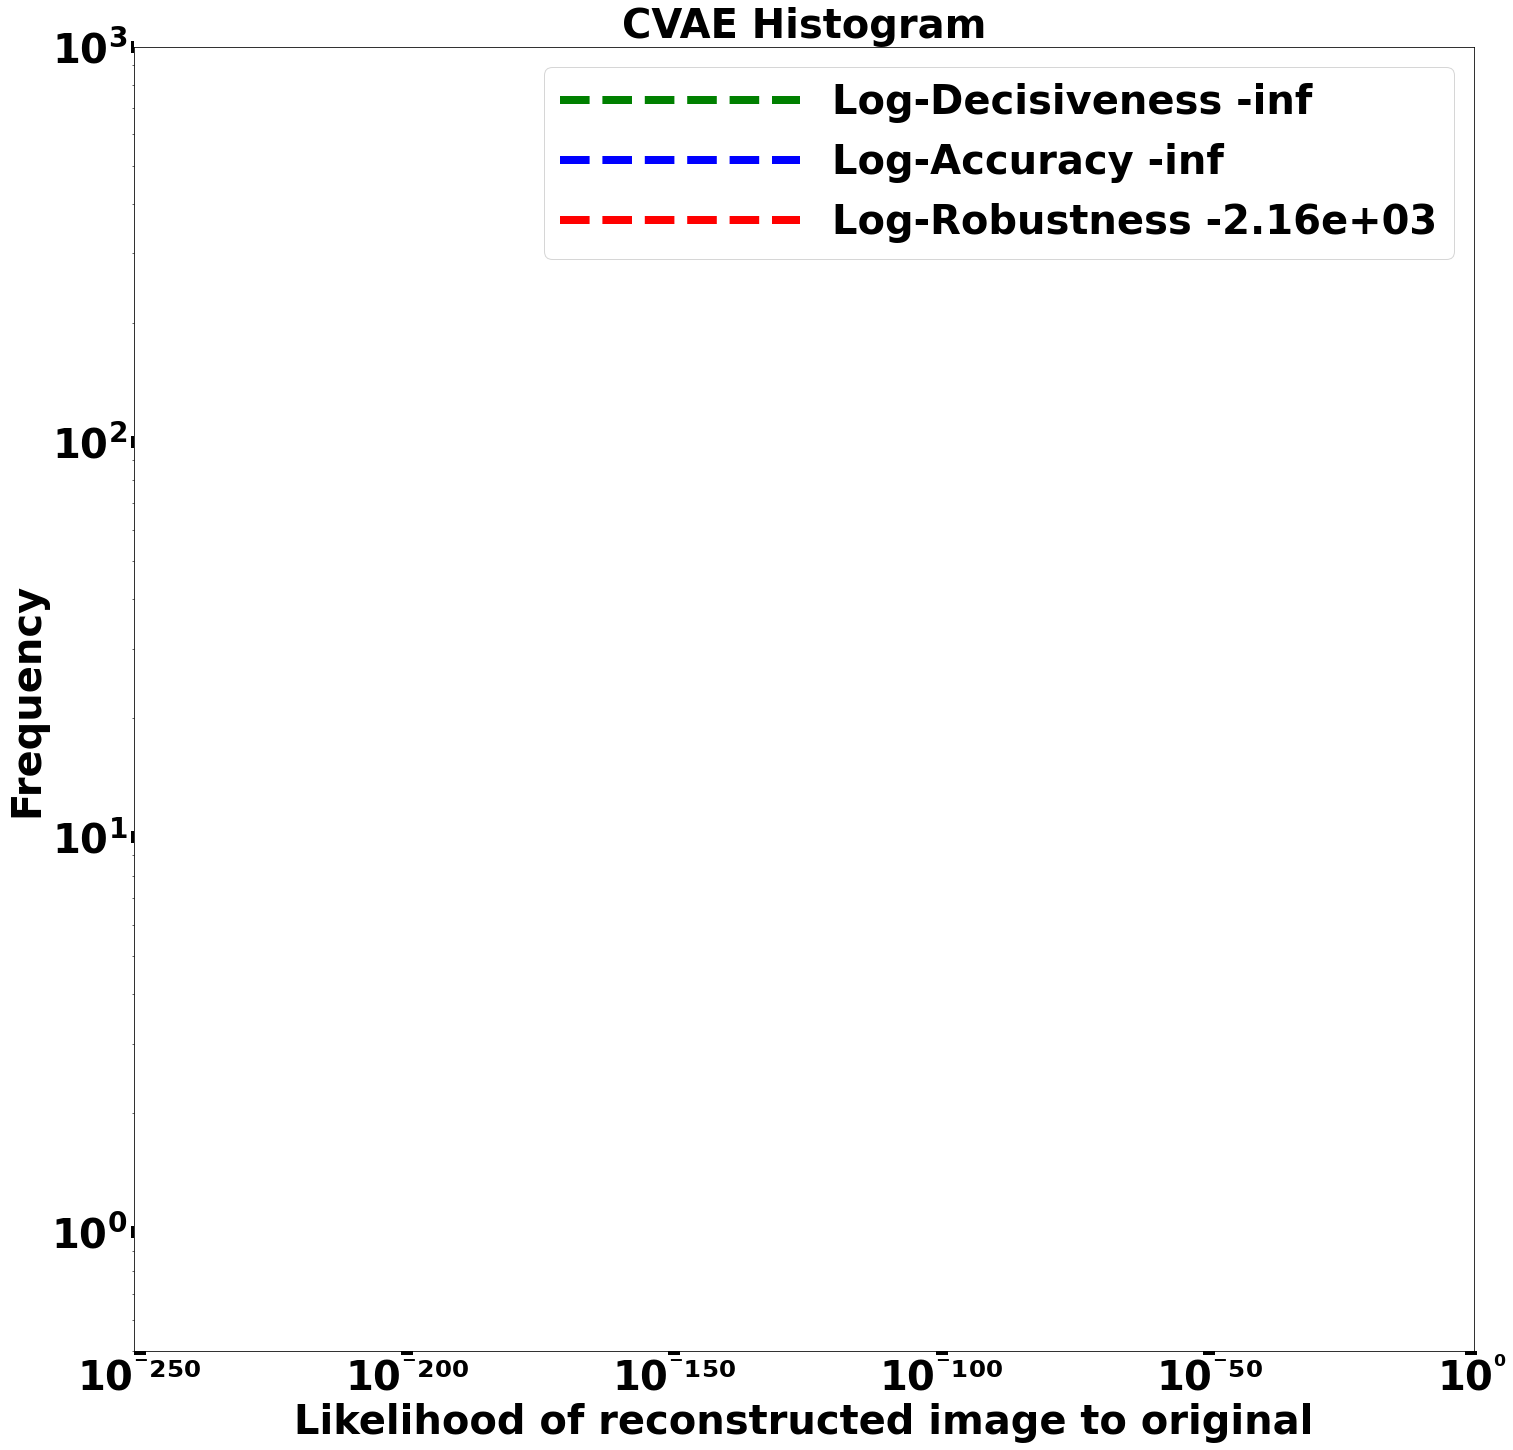

INFO:tensorflow:Assets written to: gdrive/My Drive/Colab Notebooks/coupled_vae/output/v3.2.1/seed0/model/cvae_cd1e-06_cl0.175/assets


INFO:tensorflow:Assets written to: gdrive/My Drive/Colab Notebooks/coupled_vae/output/v3.2.1/seed0/model/cvae_cd1e-06_cl0.175/assets


Decisiveness (Arithmetic Mean): 0.0
Accuracy (Geometric Mean): 0.0
Robustness (-2/3 Mean): 0.0
0.0 0.0 3.343752653609537564e-940
Run time: 18.20 min

Decisiveness (Arithmetic Mean): 0.0
Accuracy (Geometric Mean): 0.0
Robustness (-2/3 Mean): 0.0
Displaying Coupled VAE: coupling distribution = 1e-06, coupling loss = 0.2, seed = 0
2
[[nan nan]
 [nan nan]
 [nan nan]
 ...
 [nan nan]
 [nan nan]
 [nan nan]]


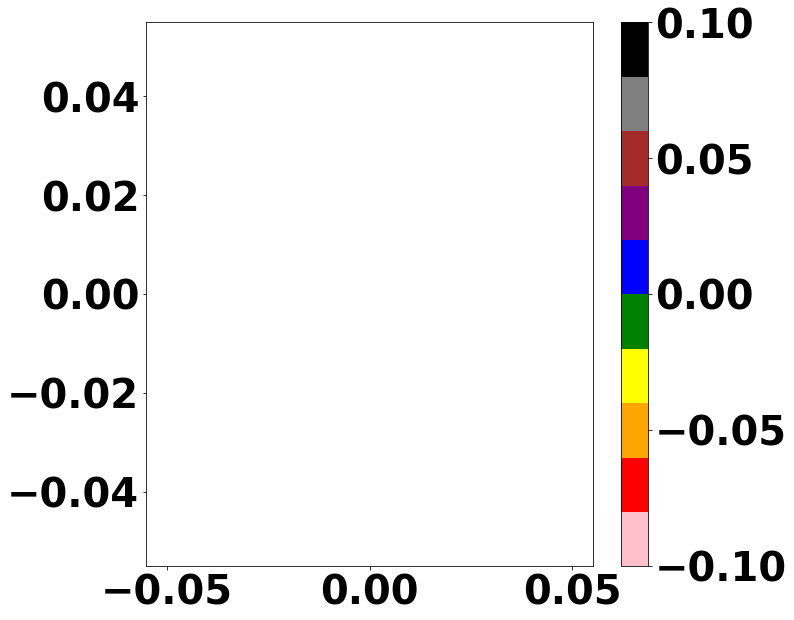

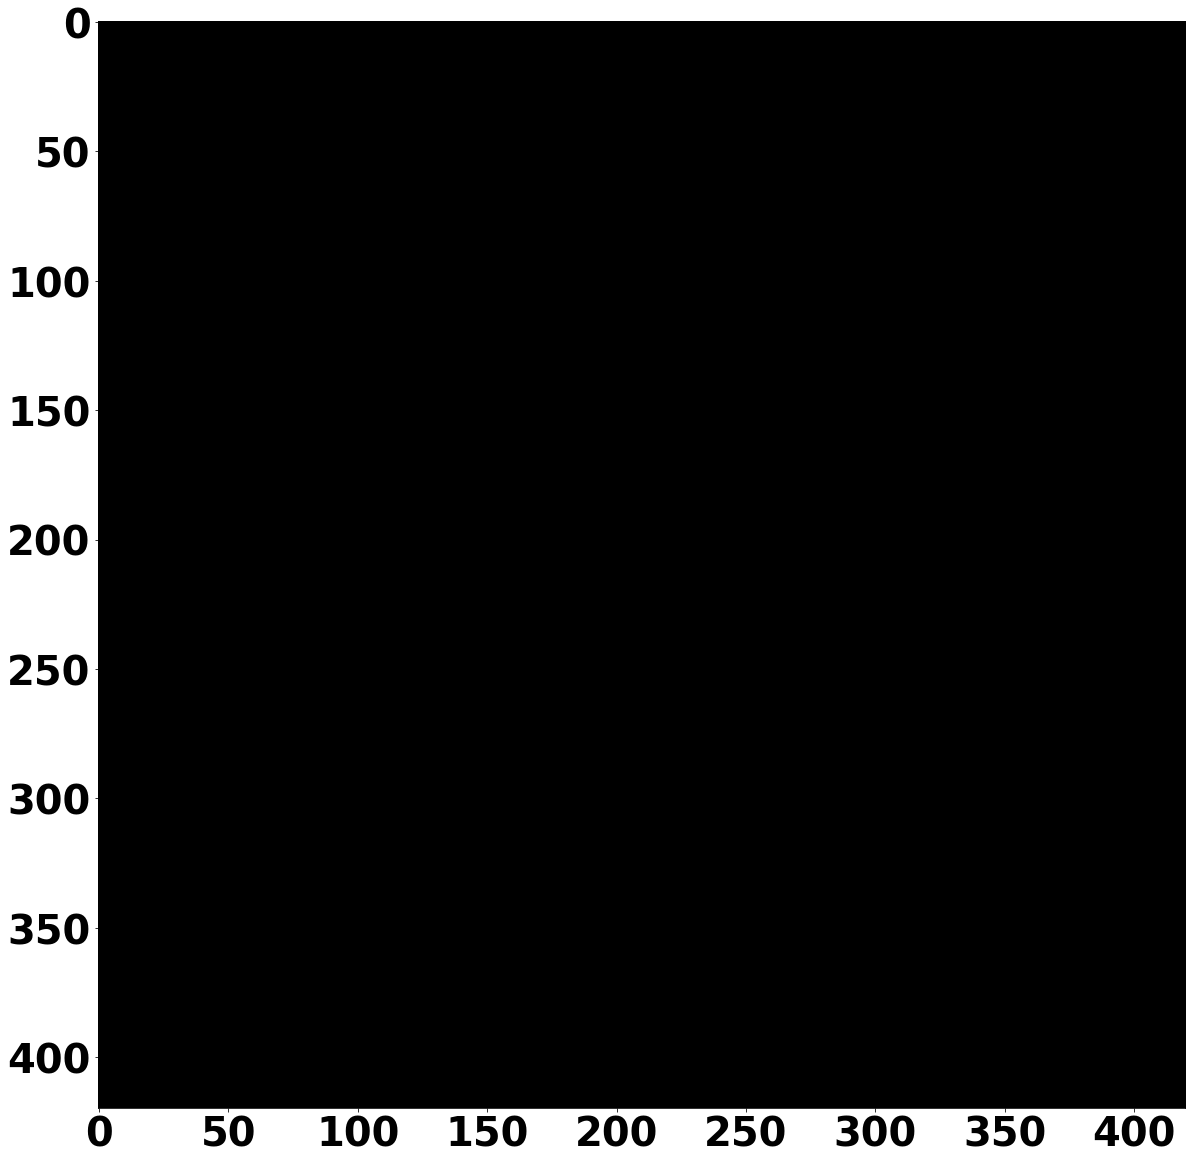

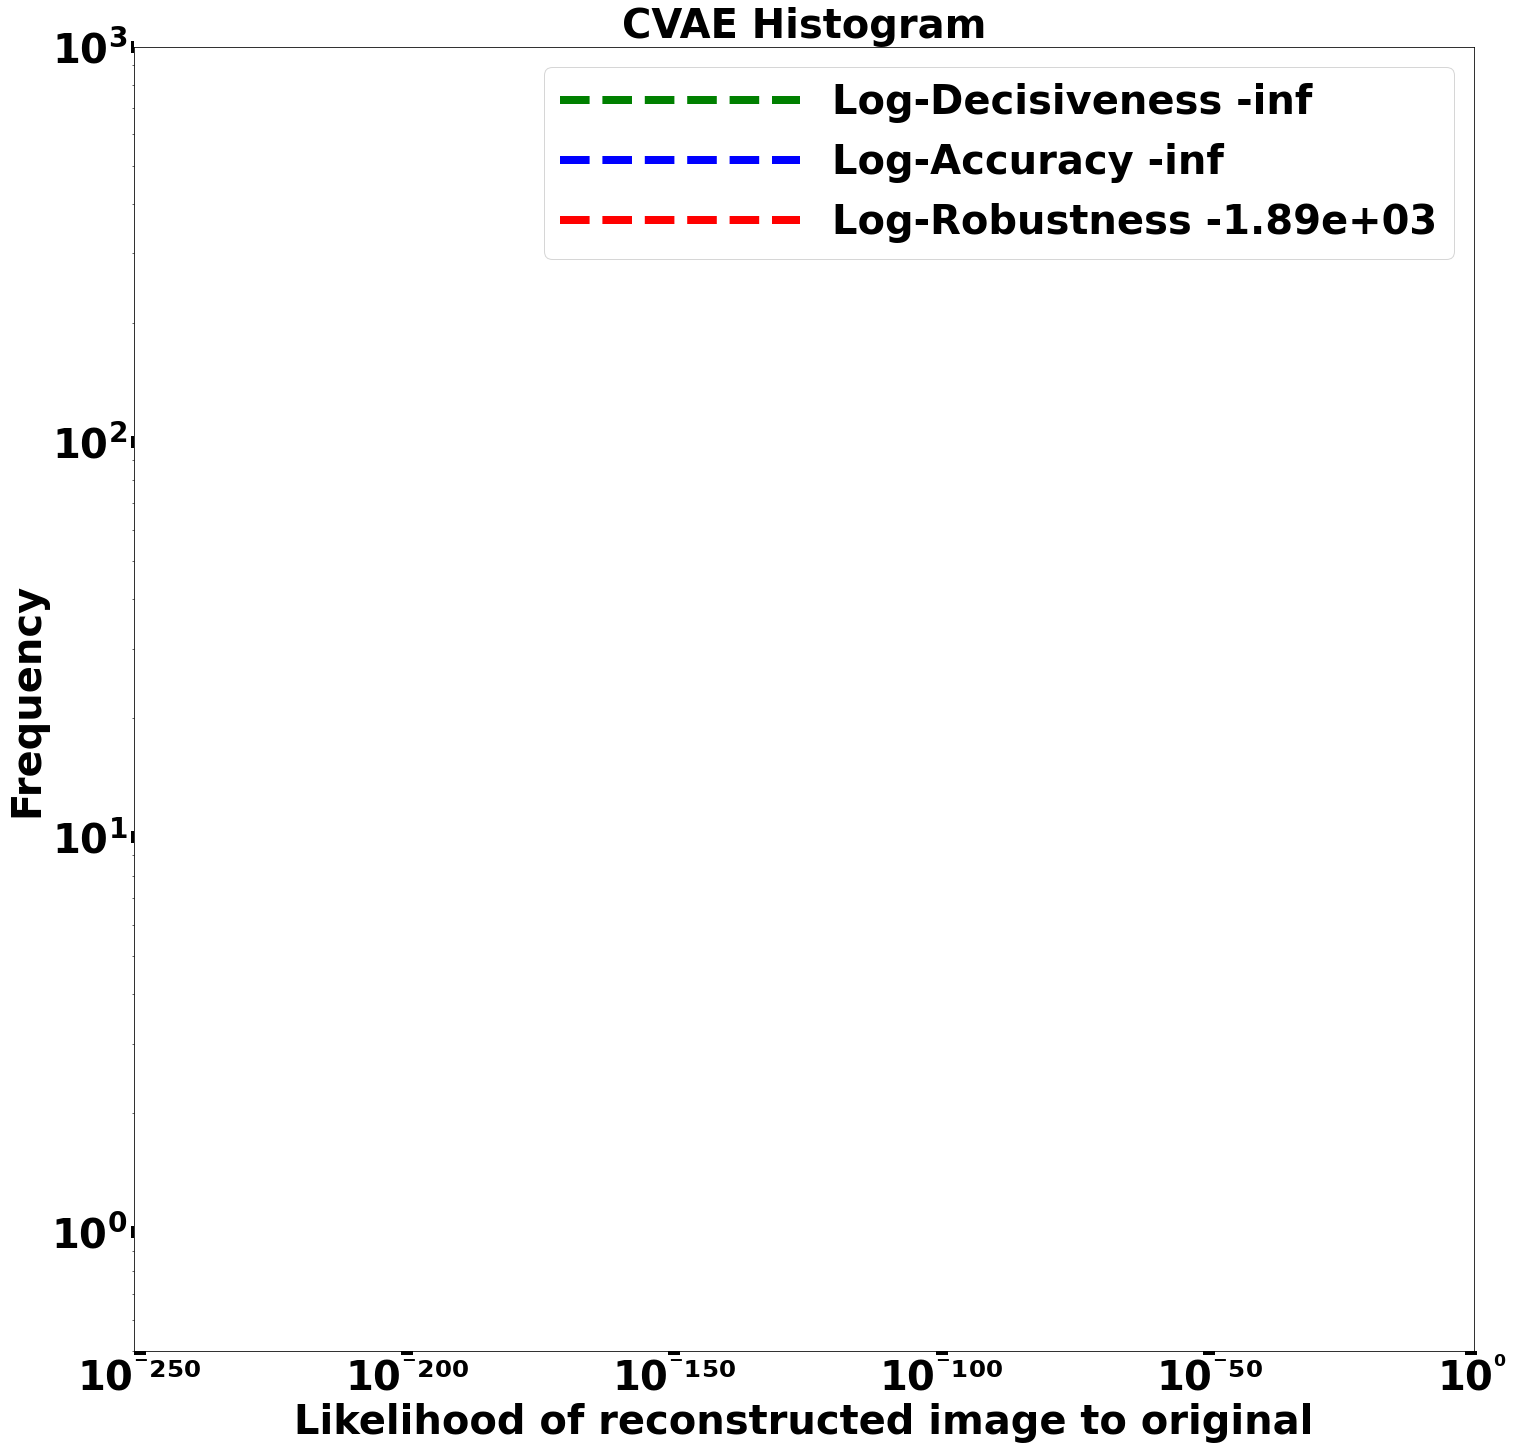

INFO:tensorflow:Assets written to: gdrive/My Drive/Colab Notebooks/coupled_vae/output/v3.2.1/seed0/model/cvae_cd1e-06_cl0.2/assets


INFO:tensorflow:Assets written to: gdrive/My Drive/Colab Notebooks/coupled_vae/output/v3.2.1/seed0/model/cvae_cd1e-06_cl0.2/assets


Decisiveness (Arithmetic Mean): 0.0
Accuracy (Geometric Mean): 0.0
Robustness (-2/3 Mean): 0.0
0.0 0.0 5.056071631221567907e-822
Run time: 18.12 min

Decisiveness (Arithmetic Mean): 0.0
Accuracy (Geometric Mean): 0.0
Robustness (-2/3 Mean): 0.0
Displaying Coupled VAE: coupling distribution = 1e-06, coupling loss = 0.225, seed = 0
2
[[nan nan]
 [nan nan]
 [nan nan]
 ...
 [nan nan]
 [nan nan]
 [nan nan]]


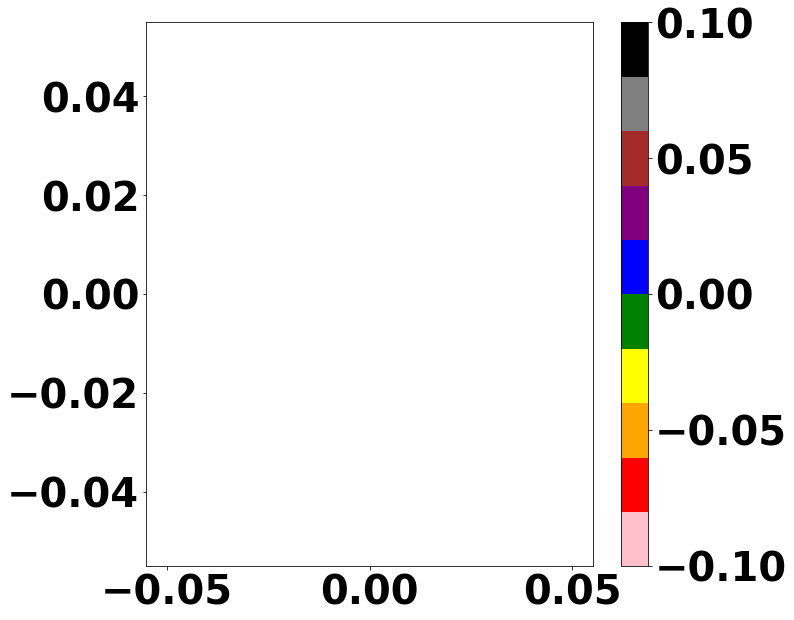

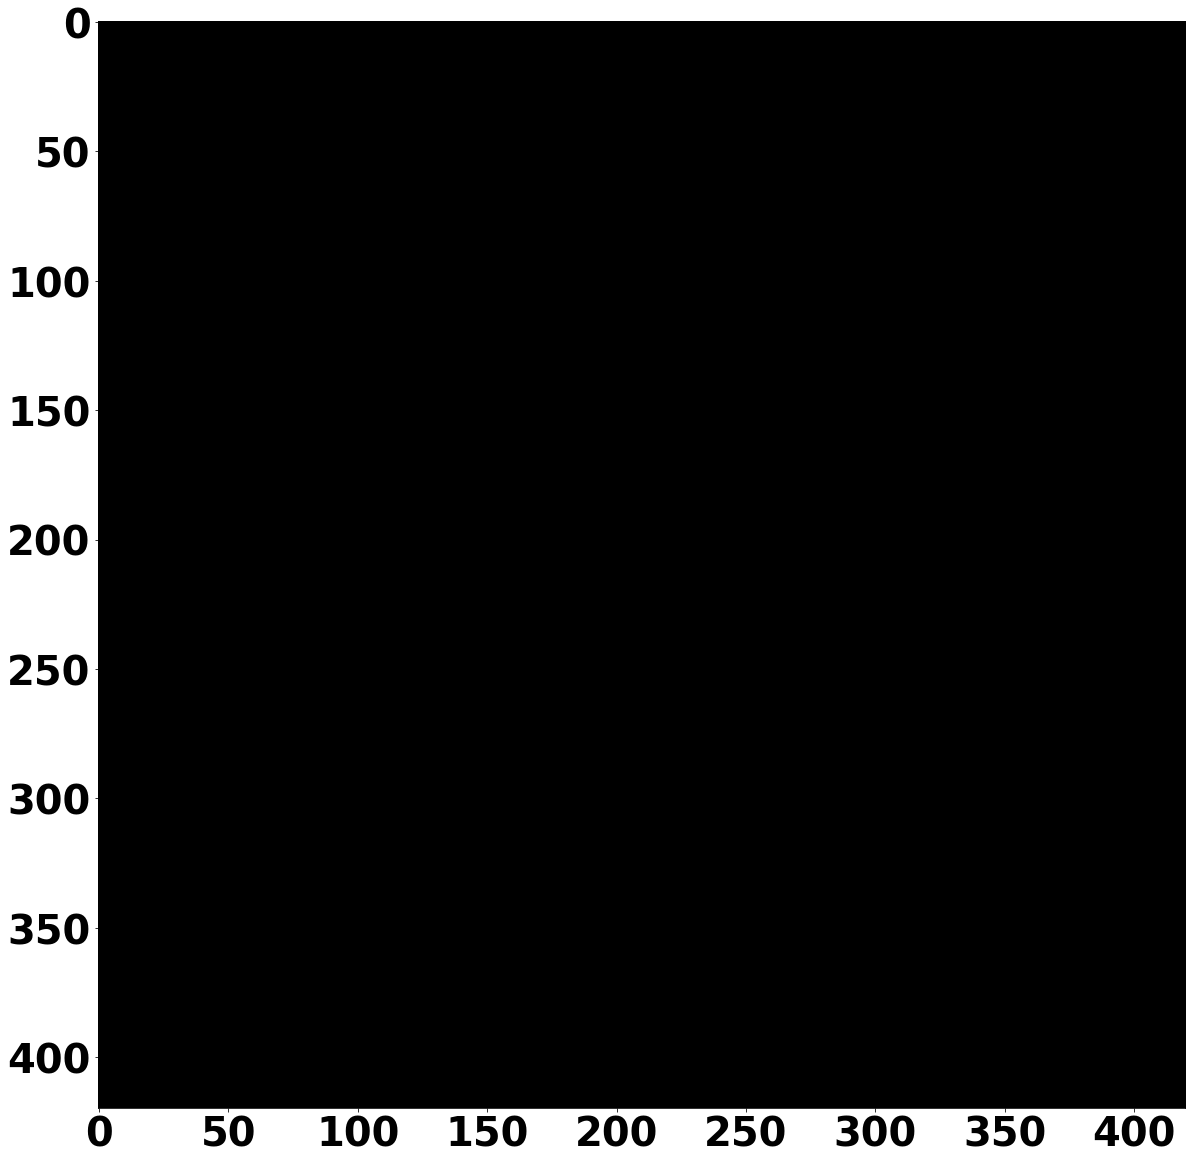

In [ ]:
%%time
for seed_key, cvae_list_seed in cvae_list.items():
    comparison_df = pd.DataFrame(columns=['coupling_dist','coupling_loss','decisiveness','accuracy','robustness'])
    for cvae_key, cvae in cvae_list_seed.items():
        start_time = time.time()
        try:
            overall_values = cvae._get_overall_values(X_test)
            temp = cvae._calculate_generalized_mean(np.array(overall_values))
            cvae.get_generalized_mean()
            cvae.display(X_test, y_test, digit_size=IMAGE_SIZE)
            cvae.save_model()
            decisiveness, accuracy, robustness = cvae.get_generalized_mean()
            print(decisiveness, accuracy, robustness)
        except ValueError:
            decisiveness, accuracy, robustness = np.NaN, np.NaN, np.NaN, 
            print("Failed to retrieve generalized mean values due to ValueError, thus set to NaN.")
        coupling_dist, coupling_loss = cvae_key.split('_')[1][2:], cvae_key.split('_')[2][2:]
        end_time = time.time()
        run_time = (end_time - start_time)/60
        print(f"Run time: {run_time:.2f} min")
        print()
        comparison_df = comparison_df.append({'coupling_dist': coupling_dist,
                                              'coupling_loss': coupling_loss,
                                              'decisiveness': decisiveness,
                                              'accuracy': accuracy,
                                              'robustness': robustness,
                                              'run_time': f'{run_time:.2f}',
                                              }, ignore_index=True
                                             )
    comparison[seed_key] = comparison_df

In [ ]:
for key, table in comparison.items():
    print(table)
    table.to_csv(f"{save_path}/{key}/result/comparison.csv", header=True, index=False)